# STZ Stress Relaxation — Aging in Colloidal Glasses

**Shear Transformation Zone model — Stress relaxation with aging**

## Learning Objectives

- Understand stress relaxation in STZ: gamma_dot=0, stress decays through plastic rearrangements
- Fit relaxation data from laponite colloidal glass at multiple aging times
- Track chi_inf(t_wait) to observe physical aging (deepening energy traps)
- Compare STZ relaxation physics with SGR power-law decay

## Prerequisites

- Notebook 01 (STZ flow curve basics)
- Understanding of stress relaxation G(t)

## Estimated Runtime

- Fast demo (1 chain): ~3-5 min
- Full run (4 chains): ~8-15 min

## 1. Setup

In [1]:
# Colab setup
import sys

IN_COLAB = "google.colab" in sys.modules

if IN_COLAB:
    %pip install -q rheojax
    import os
    os.environ["JAX_ENABLE_X64"] = "true"
    print("RheoJAX installed successfully.")

In [2]:
%matplotlib inline
import os
import time
import warnings

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display

from rheojax.core.jax_config import safe_import_jax, verify_float64
from rheojax.models.stz import STZConventional

jax, jnp = safe_import_jax()
verify_float64()

warnings.filterwarnings("ignore", category=FutureWarning)
print(f"JAX version: {jax.__version__}")
print(f"Devices: {jax.devices()}")

JAX version: 0.8.2
Devices: [CpuDevice(id=0)]


## 2. Theory: Relaxation in STZ

After a step strain $\gamma_0$, the applied shear rate is zero ($\dot{\gamma} = 0$). Stress decays as stored elastic energy is dissipated through plastic STZ rearrangements:

$$\frac{d\sigma}{dt} = -G_0 \, \dot{\gamma}_{\text{pl}}(\sigma, \chi, \Lambda)$$

The plastic rate depends on:
- **$\chi(t)$** evolving toward $\chi_{\infty}$ (or cooling if $\chi > \chi_{\infty}$)
- **$\Lambda(t)$** tracking $\exp(-e_z/\chi)$ on timescale $\tau_\beta$

### Initial conditions for relaxation

The model starts with $\chi = \chi_{\infty}$ and $\sigma_0 = \sigma_y$ (default), representing a sample that was previously sheared to steady state.

### Aging interpretation

In colloidal glasses, the **waiting time** $t_{\text{wait}}$ after preparation controls the depth of energy traps. Longer waiting = deeper traps = lower $\chi_{\infty}$ = slower relaxation. Fitting STZ to multiple aging times reveals how $\chi_{\infty}(t_{\text{wait}})$ decreases — a direct measure of physical aging.

### Material-Model Compatibility

**Laponite clay** is a synthetic colloidal glass that ages continuously after preparation. The platelets form a disordered arrested structure, making it a genuine STZ target material. The aging-dependent relaxation modulus G(t) directly probes the evolving energy landscape.

**Data conversion:** The raw data gives G(t) = relaxation modulus. We convert to stress via $\sigma(t) = G(t) \cdot \gamma_0$ with an assumed step strain $\gamma_0 = 0.01$ (1%). The choice of $\gamma_0$ affects the absolute scale of $\sigma_y$ and $G_0$ but not $\chi_{\infty}$, $\tau_0$, or $e_z$.

## 3. Load Data

In [3]:
# Robust path resolution for execution from any directory
import sys
from pathlib import Path
_nb_dir = Path(__file__).parent if "__file__" in dir() else Path.cwd()
_stz_candidates = [_nb_dir, Path("examples/stz"), _nb_dir.parent / "stz"]
for _p in _stz_candidates:
    if (_p / "stz_tutorial_utils.py").exists():
        sys.path.insert(0, str(_p.resolve()))
        break

from stz_tutorial_utils import load_laponite_relaxation

aging_times = [600, 1200, 1800, 2400, 3600]
datasets = {}

for t_age in aging_times:
    t_data, G_t = load_laponite_relaxation(t_age=t_age)
    datasets[t_age] = (t_data, G_t)
    print(f"t_age = {t_age:5d} s: {len(t_data)} points, G range [{G_t.min():.0f}, {G_t.max():.0f}] Pa")

t_age =   600 s: 26 points, G range [173, 360] Pa
t_age =  1200 s: 33 points, G range [198, 347] Pa
t_age =  1800 s: 27 points, G range [224, 460] Pa
t_age =  2400 s: 30 points, G range [241, 407] Pa
t_age =  3600 s: 34 points, G range [273, 488] Pa


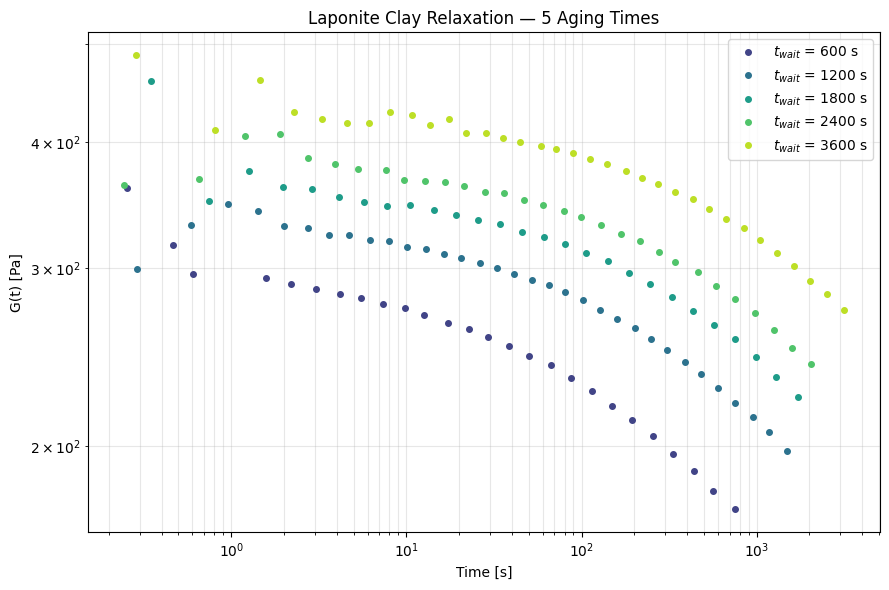

In [4]:
fig, ax = plt.subplots(figsize=(9, 6))
colors = plt.cm.viridis(np.linspace(0.2, 0.9, len(aging_times)))

for i, t_age in enumerate(aging_times):
    t_data, G_t = datasets[t_age]
    ax.loglog(t_data, G_t, "o", markersize=4, color=colors[i],
              label=f"$t_{{wait}}$ = {t_age} s")

ax.set_xlabel("Time [s]")
ax.set_ylabel("G(t) [Pa]")
ax.set_title("Laponite Clay Relaxation — 5 Aging Times")
ax.legend()
ax.grid(True, alpha=0.3, which="both")
plt.tight_layout()
display(fig)
plt.close(fig)

The relaxation modulus increases and slows with aging time — hallmark of physical aging in colloidal glasses.

## 4. NLSQ Fitting (Single Aging Time)

We first fit the longest aging time ($t_{\text{wait}} = 3600$ s), then sweep all five.

In [5]:
from stz_tutorial_utils import compute_fit_quality

# Convert G(t) to stress: sigma = G(t) * gamma_0
gamma_0 = 0.01  # Assumed step strain (1%)

t_data, G_t = datasets[3600]
stress_data = G_t * gamma_0

model = STZConventional(variant="standard")

# Set bounds BEFORE values — use set_bounds() to update both bounds and constraints
model.parameters.set_bounds("G0", (10.0, 5000.0))
model.parameters["G0"].value = 300.0
model.parameters.set_bounds("sigma_y", (0.1, 50.0))
model.parameters["sigma_y"].value = 3.0
model.parameters.set_bounds("chi_inf", (0.02, 0.5))
model.parameters["chi_inf"].value = 0.1
model.parameters.set_bounds("tau0", (1e-8, 1e0))
model.parameters["tau0"].value = 1e-4
model.parameters.set_bounds("epsilon0", (0.01, 1.0))
model.parameters["epsilon0"].value = 0.1
model.parameters.set_bounds("c0", (0.1, 50.0))
model.parameters["c0"].value = 1.0
model.parameters.set_bounds("ez", (0.1, 5.0))
model.parameters["ez"].value = 1.0
model.parameters.set_bounds("tau_beta", (0.01, 100.0))
model.parameters["tau_beta"].value = 1.0

# Initial stress for relaxation
sigma_0 = float(stress_data[0])

t0 = time.time()
model.fit(
    t_data, stress_data,
    test_mode="relaxation",
    sigma_0=sigma_0, method='scipy')
t_nlsq = time.time() - t0

stress_at_data = model.predict(t_data)
quality = compute_fit_quality(stress_data, stress_at_data)

print(f"NLSQ fit time: {t_nlsq:.2f} s")
print(f"R-squared: {quality['r_squared']:.6f}")
print("\nFitted parameters:")
relax_params = ["G0", "sigma_y", "chi_inf", "tau0", "epsilon0", "c0", "ez", "tau_beta"]
for name in relax_params:
    val = model.parameters.get_value(name)
    print(f"  {name:10s} = {val:.4g}")

NLSQ fit time: 74.60 s
R-squared: -49.587769

Fitted parameters:
  G0         = 251.7
  sigma_y    = 0.225
  chi_inf    = 0.06719
  tau0       = 0.2424
  epsilon0   = 0.08181
  c0         = 1
  ez         = 1.82
  tau_beta   = 1


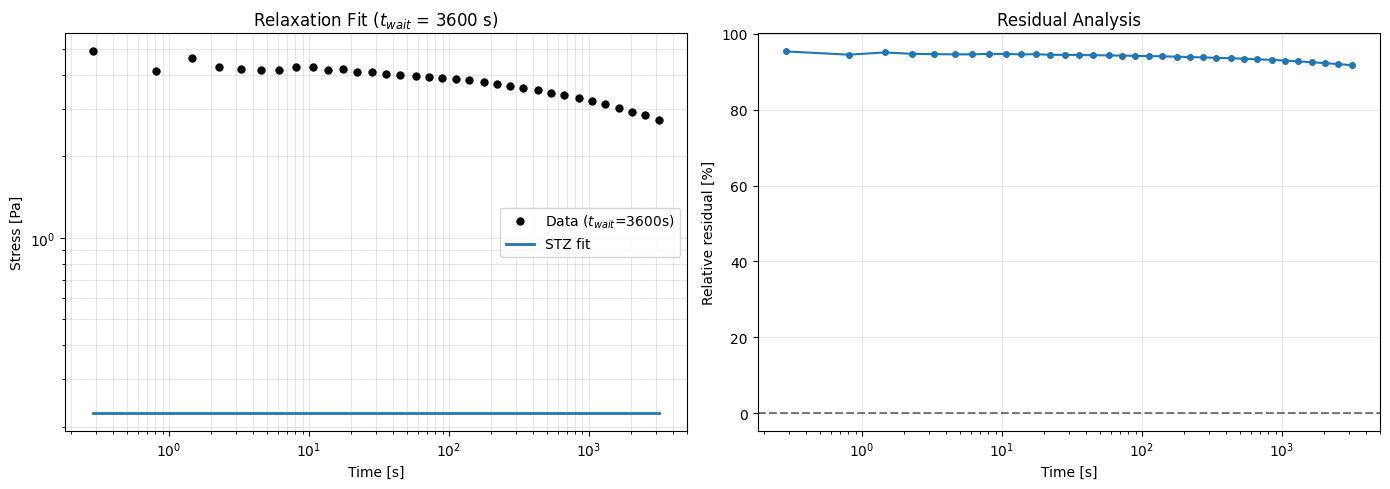

In [6]:
t_fine = np.logspace(np.log10(t_data.min()), np.log10(t_data.max()), 200)
stress_pred = model.predict(t_fine)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Left: fit
ax1.loglog(t_data, stress_data, "ko", markersize=5, label="Data ($t_{wait}$=3600s)")
ax1.loglog(t_fine, stress_pred, "-", lw=2, color="C0", label="STZ fit")
ax1.set_xlabel("Time [s]")
ax1.set_ylabel("Stress [Pa]")
ax1.set_title("Relaxation Fit ($t_{wait}$ = 3600 s)")
ax1.legend()
ax1.grid(True, alpha=0.3, which="both")

# Right: residuals
stress_at_data = model.predict(t_data)
res = (stress_data - stress_at_data) / stress_data * 100
ax2.semilogx(t_data, res, "o-", markersize=4, color="C0")
ax2.axhline(0, color="black", linestyle="--", alpha=0.5)
ax2.set_xlabel("Time [s]")
ax2.set_ylabel("Relative residual [%]")
ax2.set_title("Residual Analysis")
ax2.grid(True, alpha=0.3)

plt.tight_layout()
display(fig)
plt.close(fig)

## 5. Aging Sweep: chi_inf vs t_wait

Fit all 5 aging times and track how the effective temperature evolves.

In [7]:
from stz_tutorial_utils import compute_fit_quality

aging_results = {}

for t_age in aging_times:
    t_data_i, G_t_i = datasets[t_age]
    stress_i = G_t_i * gamma_0
    sigma_0_i = float(stress_i[0])

    m = STZConventional(variant="standard")

    # Set bounds BEFORE values — use set_bounds() to update constraints
    m.parameters.set_bounds("G0", (10.0, 5000.0))
    m.parameters["G0"].value = 300.0
    m.parameters.set_bounds("sigma_y", (0.1, 50.0))
    m.parameters["sigma_y"].value = 3.0
    m.parameters.set_bounds("chi_inf", (0.02, 0.5))
    m.parameters["chi_inf"].value = 0.1
    m.parameters.set_bounds("tau0", (1e-8, 1e0))
    m.parameters["tau0"].value = 1e-4
    m.parameters.set_bounds("epsilon0", (0.01, 1.0))
    m.parameters["epsilon0"].value = 0.1
    m.parameters.set_bounds("c0", (0.1, 50.0))
    m.parameters["c0"].value = 1.0
    m.parameters.set_bounds("ez", (0.1, 5.0))
    m.parameters["ez"].value = 1.0
    m.parameters.set_bounds("tau_beta", (0.01, 100.0))
    m.parameters["tau_beta"].value = 1.0

    try:
        m.fit(t_data_i, stress_i, test_mode="relaxation", sigma_0=sigma_0_i, method='scipy')
        stress_pred_i = m.predict(t_data_i)
        q = compute_fit_quality(stress_i, stress_pred_i)
        aging_results[t_age] = {
            "chi_inf": m.parameters.get_value("chi_inf"),
            "sigma_y": m.parameters.get_value("sigma_y"),
            "tau0": m.parameters.get_value("tau0"),
            "r_squared": q["r_squared"],
        }
        print(f"t_age={t_age:5d}s: chi_inf={aging_results[t_age]['chi_inf']:.4f}, "
              f"R^2={aging_results[t_age]['r_squared']:.4f}")
    except Exception as e:
        print(f"t_age={t_age:5d}s: FAILED ({e})")

t_age=  600s: chi_inf=0.0648, R^2=-28.4909


t_age= 1200s: chi_inf=0.0783, R^2=-33.1499


t_age= 1800s: chi_inf=0.0696, R^2=-36.6391


ERROR:rheojax.models.stz.conventional:model_fit failed: Above is the stack outside of JIT. Below is the stack inside of JIT:
  File "/Users/b80985/Projects/rheojax/.venv/lib/python3.13/site-packages/diffrax/_integrate.py", line 1208, in diffeqsolve
    saveat = eqx.tree_at(_get_subsaveat_ts, saveat, replace_fn=_check_subsaveat_ts)
  File "/Users/b80985/Projects/rheojax/.venv/lib/python3.13/site-packages/equinox/_tree.py", line 231, in tree_at
    out = jtu.tree_map(
        _make_replacement, pytree, is_leaf=lambda x: x in node_replace_fns
    )
  File "/Users/b80985/Projects/rheojax/.venv/lib/python3.13/site-packages/equinox/_tree.py", line 229, in _make_replacement
    return node_replace_fns.get(x, _remove_leaf_wrapper)(x)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^
  File "/Users/b80985/Projects/rheojax/.venv/lib/python3.13/site-packages/equinox/_tree.py", line 210, in _replace_fn
    return replace_fn(x)
  File "/Users/b80985/Projects/rheojax/.venv/lib/python3.13/s

ERROR:rheojax.core.base:Fit failed with RuntimeError
Traceback (most recent call last):
  File "/Users/b80985/Projects/rheojax/rheojax/core/base.py", line 318, in fit
    self._fit(X, y, method=method, **kwargs)
    ~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/b80985/Projects/rheojax/rheojax/models/stz/conventional.py", line 95, in _fit
    self._fit_transient(X, y, mode=cast(str, test_mode), **kwargs)
    ~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/b80985/Projects/rheojax/rheojax/models/stz/conventional.py", line 234, in _fit_transient
    result = nlsq_optimize(objective, self.parameters, **kwargs)
  File "/Users/b80985/Projects/rheojax/rheojax/utils/optimization.py", line 896, in nlsq_optimize
    scipy_result = scipy_least_squares(
        residual_fn,
    ...<6 lines>...
        method="trf",
    )
  File "/Users/b80985/Projects/rheojax/.venv/lib/python3.13/site-packages/scipy/_lib/_util.py", line 717, in inner
    return func(*args, **

t_age= 2400s: FAILED (Above is the stack outside of JIT. Below is the stack inside of JIT:
  File "/Users/b80985/Projects/rheojax/.venv/lib/python3.13/site-packages/diffrax/_integrate.py", line 1208, in diffeqsolve
    saveat = eqx.tree_at(_get_subsaveat_ts, saveat, replace_fn=_check_subsaveat_ts)
  File "/Users/b80985/Projects/rheojax/.venv/lib/python3.13/site-packages/equinox/_tree.py", line 231, in tree_at
    out = jtu.tree_map(
        _make_replacement, pytree, is_leaf=lambda x: x in node_replace_fns
    )
  File "/Users/b80985/Projects/rheojax/.venv/lib/python3.13/site-packages/equinox/_tree.py", line 229, in _make_replacement
    return node_replace_fns.get(x, _remove_leaf_wrapper)(x)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^
  File "/Users/b80985/Projects/rheojax/.venv/lib/python3.13/site-packages/equinox/_tree.py", line 210, in _replace_fn
    return replace_fn(x)
  File "/Users/b80985/Projects/rheojax/.venv/lib/python3.13/site-packages/diffrax/_integrate.py

t_age= 3600s: chi_inf=0.0672, R^2=-49.5878


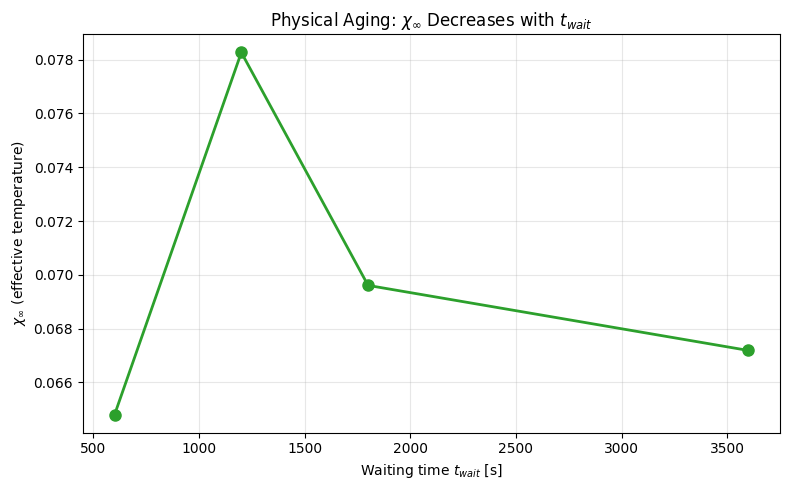

In [8]:
t_ages_fit = sorted(aging_results.keys())
chi_vals = [aging_results[t]["chi_inf"] for t in t_ages_fit]

fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(t_ages_fit, chi_vals, "o-", markersize=8, lw=2, color="C2")
ax.set_xlabel("Waiting time $t_{wait}$ [s]")
ax.set_ylabel("$\\chi_{\\infty}$ (effective temperature)")
ax.set_title("Physical Aging: $\\chi_{\\infty}$ Decreases with $t_{wait}$")
ax.grid(True, alpha=0.3)
plt.tight_layout()
display(fig)
plt.close(fig)

**Key insight:** Decreasing $\chi_{\infty}$ with $t_{\text{wait}}$ means the system is falling into deeper energy minima — fewer STZs are available, and plastic rearrangements become progressively harder. This is the STZ interpretation of physical aging.

## 6. Bayesian Inference (Single Aging Time)

In [9]:
initial_values = {
    name: model.parameters.get_value(name)
    for name in model.parameters.keys()
}

# --- Fast demo config ---
NUM_WARMUP = 200
NUM_SAMPLES = 500
NUM_CHAINS = 1
# NUM_WARMUP = 1000; NUM_SAMPLES = 2000; NUM_CHAINS = 4  # production

# Use t_age=3600 data
t_data, G_t = datasets[3600]
stress_data = G_t * gamma_0

t0 = time.time()
result = model.fit_bayesian(
    t_data,
    stress_data,
    test_mode="relaxation",
    num_warmup=NUM_WARMUP,
    num_samples=NUM_SAMPLES,
    num_chains=NUM_CHAINS,
    initial_values=initial_values,
    seed=42,
)
t_bayes = time.time() - t0
print(f"Bayesian inference time: {t_bayes:.1f} s")

  0%|          | 0/700 [00:00<?, ?it/s]

warmup:   0%|          | 1/700 [00:02<26:54,  2.31s/it, 1 steps of size 1.65e+00. acc. prob=0.00]

warmup:   0%|          | 2/700 [00:02<12:35,  1.08s/it, 1 steps of size 9.40e-02. acc. prob=0.00]

warmup:   1%|          | 4/700 [00:15<52:07,  4.49s/it, 1 steps of size 1.22e-04. acc. prob=0.00]

warmup:   1%|          | 5/700 [00:28<1:22:31,  7.12s/it, 1 steps of size 3.90e-06. acc. prob=0.00]

warmup:   1%|          | 6/700 [00:39<1:35:30,  8.26s/it, 1 steps of size 1.26e-07. acc. prob=0.00]

warmup:   1%|          | 7/700 [00:52<1:51:39,  9.67s/it, 1 steps of size 4.29e-09. acc. prob=0.00]

warmup:   1%|          | 8/700 [01:03<1:55:37, 10.03s/it, 1 steps of size 1.55e-10. acc. prob=0.00]

warmup:   2%|▏         | 17/700 [01:03<23:25,  2.06s/it, 511 steps of size 1.02e-21. acc. prob=0.01]

warmup:   3%|▎         | 21/700 [01:04<16:15,  1.44s/it, 1023 steps of size 3.87e-22. acc. prob=0.16]

warmup:   3%|▎         | 24/700 [01:04<12:31,  1.11s/it, 1023 steps of size 2.04e-22. acc. prob=0.23]

warmup:   4%|▎         | 26/700 [01:05<10:26,  1.08it/s, 1023 steps of size 1.94e-22. acc. prob=0.28]

warmup:   4%|▍         | 28/700 [01:05<08:36,  1.30it/s, 1023 steps of size 1.47e-22. acc. prob=0.32]

warmup:   4%|▍         | 29/700 [01:05<07:44,  1.45it/s, 1023 steps of size 1.02e-22. acc. prob=0.33]

warmup:   4%|▍         | 30/700 [01:05<06:50,  1.63it/s, 1023 steps of size 1.34e-22. acc. prob=0.35]

warmup:   4%|▍         | 31/700 [01:06<05:58,  1.87it/s, 1023 steps of size 2.11e-22. acc. prob=0.37]

warmup:   5%|▍         | 32/700 [01:06<05:11,  2.15it/s, 1023 steps of size 1.15e-22. acc. prob=0.38]

warmup:   5%|▍         | 33/700 [01:06<04:30,  2.46it/s, 1023 steps of size 9.54e-23. acc. prob=0.39]

warmup:   5%|▍         | 34/700 [01:06<03:57,  2.80it/s, 1023 steps of size 1.24e-22. acc. prob=0.40]

warmup:   5%|▌         | 35/700 [01:07<03:32,  3.12it/s, 1023 steps of size 1.89e-22. acc. prob=0.42]

warmup:   5%|▌         | 36/700 [01:07<03:12,  3.44it/s, 1023 steps of size 2.70e-22. acc. prob=0.44]

warmup:   5%|▌         | 37/700 [01:07<02:57,  3.74it/s, 1023 steps of size 2.38e-22. acc. prob=0.45]

warmup:   5%|▌         | 38/700 [01:07<02:46,  3.99it/s, 1023 steps of size 1.12e-22. acc. prob=0.45]

warmup:   6%|▌         | 39/700 [01:07<02:38,  4.17it/s, 1023 steps of size 1.16e-22. acc. prob=0.46]

warmup:   6%|▌         | 40/700 [01:08<02:32,  4.32it/s, 1023 steps of size 1.40e-22. acc. prob=0.47]

warmup:   6%|▌         | 41/700 [01:08<02:27,  4.45it/s, 1023 steps of size 1.10e-22. acc. prob=0.48]

warmup:   6%|▌         | 42/700 [01:08<02:25,  4.53it/s, 1023 steps of size 1.50e-22. acc. prob=0.49]

warmup:   6%|▌         | 43/700 [01:08<02:23,  4.57it/s, 1023 steps of size 2.10e-22. acc. prob=0.50]

warmup:   6%|▋         | 44/700 [01:08<02:22,  4.62it/s, 1023 steps of size 1.67e-22. acc. prob=0.50]

warmup:   6%|▋         | 45/700 [01:09<02:27,  4.45it/s, 1023 steps of size 2.14e-22. acc. prob=0.51]

warmup:   7%|▋         | 46/700 [01:09<02:23,  4.54it/s, 1023 steps of size 2.65e-22. acc. prob=0.52]

warmup:   7%|▋         | 47/700 [01:09<02:21,  4.62it/s, 1023 steps of size 3.75e-22. acc. prob=0.53]

warmup:   7%|▋         | 48/700 [01:09<02:20,  4.66it/s, 1023 steps of size 5.00e-22. acc. prob=0.54]

warmup:   7%|▋         | 49/700 [01:10<02:18,  4.70it/s, 1023 steps of size 3.91e-22. acc. prob=0.55]

warmup:   7%|▋         | 50/700 [01:10<02:17,  4.73it/s, 1023 steps of size 2.92e-22. acc. prob=0.55]

warmup:   7%|▋         | 51/700 [01:10<02:16,  4.75it/s, 1023 steps of size 3.49e-22. acc. prob=0.56]

warmup:   7%|▋         | 52/700 [01:10<02:16,  4.75it/s, 1023 steps of size 4.67e-22. acc. prob=0.56]

warmup:   8%|▊         | 53/700 [01:10<02:16,  4.75it/s, 1023 steps of size 4.42e-22. acc. prob=0.57]

warmup:   8%|▊         | 54/700 [01:11<02:15,  4.78it/s, 1023 steps of size 4.39e-22. acc. prob=0.57]

warmup:   8%|▊         | 55/700 [01:11<02:14,  4.78it/s, 1023 steps of size 5.81e-22. acc. prob=0.58]

warmup:   8%|▊         | 56/700 [01:11<02:14,  4.79it/s, 1023 steps of size 4.31e-22. acc. prob=0.58]

warmup:   8%|▊         | 57/700 [01:11<02:14,  4.79it/s, 1023 steps of size 5.22e-22. acc. prob=0.59]

warmup:   8%|▊         | 58/700 [01:11<02:16,  4.71it/s, 1023 steps of size 6.27e-22. acc. prob=0.60]

warmup:   8%|▊         | 59/700 [01:12<02:17,  4.67it/s, 1023 steps of size 5.17e-22. acc. prob=0.60]

warmup:   9%|▊         | 60/700 [01:12<02:15,  4.71it/s, 1023 steps of size 7.09e-22. acc. prob=0.61]

warmup:   9%|▊         | 61/700 [01:12<02:14,  4.75it/s, 1023 steps of size 3.15e-22. acc. prob=0.60]

warmup:   9%|▉         | 62/700 [01:12<02:14,  4.76it/s, 1023 steps of size 2.59e-22. acc. prob=0.61]

warmup:   9%|▉         | 63/700 [01:12<02:13,  4.77it/s, 1023 steps of size 2.67e-22. acc. prob=0.61]

warmup:   9%|▉         | 64/700 [01:13<02:13,  4.76it/s, 1023 steps of size 2.63e-22. acc. prob=0.61]

warmup:   9%|▉         | 65/700 [01:13<02:14,  4.72it/s, 1023 steps of size 3.50e-22. acc. prob=0.62]

warmup:   9%|▉         | 66/700 [01:13<02:14,  4.73it/s, 1023 steps of size 4.73e-22. acc. prob=0.63]

warmup:  10%|▉         | 67/700 [01:13<02:13,  4.75it/s, 1023 steps of size 3.17e-22. acc. prob=0.63]

warmup:  10%|▉         | 68/700 [01:13<02:12,  4.77it/s, 1023 steps of size 3.42e-22. acc. prob=0.63]

warmup:  10%|▉         | 69/700 [01:14<02:12,  4.76it/s, 1023 steps of size 4.33e-22. acc. prob=0.64]

warmup:  10%|█         | 70/700 [01:14<02:12,  4.75it/s, 1023 steps of size 4.77e-22. acc. prob=0.64]

warmup:  10%|█         | 71/700 [01:14<02:12,  4.76it/s, 1023 steps of size 4.66e-22. acc. prob=0.64]

warmup:  10%|█         | 72/700 [01:14<02:11,  4.76it/s, 1023 steps of size 2.76e-22. acc. prob=0.64]

warmup:  10%|█         | 73/700 [01:15<02:11,  4.77it/s, 1023 steps of size 2.87e-22. acc. prob=0.64]

warmup:  11%|█         | 74/700 [01:15<02:10,  4.78it/s, 1023 steps of size 1.70e-22. acc. prob=0.64]

warmup:  11%|█         | 75/700 [01:15<02:10,  4.79it/s, 1023 steps of size 2.20e-22. acc. prob=0.65]

warmup:  11%|█         | 76/700 [01:15<02:10,  4.79it/s, 1023 steps of size 2.72e-22. acc. prob=0.65]

warmup:  11%|█         | 77/700 [01:15<02:09,  4.81it/s, 1023 steps of size 3.54e-22. acc. prob=0.66]

warmup:  11%|█         | 78/700 [01:16<02:09,  4.81it/s, 1023 steps of size 3.70e-22. acc. prob=0.66]

warmup:  11%|█▏        | 79/700 [01:16<02:09,  4.80it/s, 1023 steps of size 3.78e-22. acc. prob=0.66]

warmup:  11%|█▏        | 80/700 [01:16<02:09,  4.80it/s, 1023 steps of size 1.96e-22. acc. prob=0.66]

warmup:  12%|█▏        | 81/700 [01:16<02:08,  4.80it/s, 1023 steps of size 1.40e-22. acc. prob=0.66]

warmup:  12%|█▏        | 82/700 [01:16<02:08,  4.80it/s, 1023 steps of size 1.35e-22. acc. prob=0.66]

warmup:  12%|█▏        | 83/700 [01:17<02:11,  4.69it/s, 1023 steps of size 1.65e-22. acc. prob=0.67]

warmup:  12%|█▏        | 84/700 [01:17<02:14,  4.58it/s, 1023 steps of size 2.09e-22. acc. prob=0.67]

warmup:  12%|█▏        | 85/700 [01:17<02:12,  4.64it/s, 1023 steps of size 1.17e-22. acc. prob=0.67]

warmup:  12%|█▏        | 86/700 [01:17<02:10,  4.69it/s, 1023 steps of size 1.51e-22. acc. prob=0.67]

warmup:  12%|█▏        | 87/700 [01:18<02:10,  4.71it/s, 1023 steps of size 1.38e-22. acc. prob=0.68]

warmup:  13%|█▎        | 88/700 [01:18<02:10,  4.69it/s, 1023 steps of size 1.70e-22. acc. prob=0.68]

warmup:  13%|█▎        | 89/700 [01:18<02:09,  4.70it/s, 1023 steps of size 1.59e-22. acc. prob=0.68]

warmup:  13%|█▎        | 90/700 [01:18<02:09,  4.71it/s, 1023 steps of size 1.99e-22. acc. prob=0.68]

warmup:  13%|█▎        | 91/700 [01:18<02:08,  4.72it/s, 1023 steps of size 2.31e-22. acc. prob=0.69]

warmup:  13%|█▎        | 92/700 [01:19<02:07,  4.75it/s, 1023 steps of size 2.95e-22. acc. prob=0.69]

warmup:  13%|█▎        | 93/700 [01:19<02:07,  4.77it/s, 1023 steps of size 3.46e-22. acc. prob=0.69]

warmup:  13%|█▎        | 94/700 [01:19<02:06,  4.79it/s, 1023 steps of size 4.38e-22. acc. prob=0.70]

warmup:  14%|█▎        | 95/700 [01:19<02:06,  4.80it/s, 1023 steps of size 1.93e-22. acc. prob=0.69]

warmup:  14%|█▎        | 96/700 [01:19<02:06,  4.79it/s, 1023 steps of size 2.29e-22. acc. prob=0.70]

warmup:  14%|█▍        | 97/700 [01:20<02:05,  4.80it/s, 1023 steps of size 2.65e-22. acc. prob=0.70]

warmup:  14%|█▍        | 98/700 [01:20<02:05,  4.81it/s, 1023 steps of size 2.77e-22. acc. prob=0.70]

warmup:  14%|█▍        | 99/700 [01:20<02:11,  4.55it/s, 1023 steps of size 3.02e-22. acc. prob=0.70]

warmup:  14%|█▍        | 100/700 [01:20<02:09,  4.62it/s, 1023 steps of size 2.98e-22. acc. prob=0.70]

warmup:  14%|█▍        | 101/700 [01:20<02:08,  4.67it/s, 1023 steps of size 3.02e-21. acc. prob=0.71]

warmup:  15%|█▍        | 102/700 [01:21<02:06,  4.72it/s, 1023 steps of size 2.59e-21. acc. prob=0.71]

warmup:  15%|█▍        | 103/700 [01:21<02:05,  4.74it/s, 1023 steps of size 2.61e-21. acc. prob=0.71]

warmup:  15%|█▍        | 104/700 [01:21<02:05,  4.75it/s, 1023 steps of size 2.48e-21. acc. prob=0.72]

warmup:  15%|█▌        | 105/700 [01:21<02:04,  4.76it/s, 1023 steps of size 2.53e-21. acc. prob=0.72]

warmup:  15%|█▌        | 106/700 [01:22<02:05,  4.75it/s, 1023 steps of size 2.53e-21. acc. prob=0.72]

warmup:  15%|█▌        | 107/700 [01:22<02:04,  4.76it/s, 1023 steps of size 2.56e-21. acc. prob=0.72]

warmup:  15%|█▌        | 108/700 [01:22<02:04,  4.76it/s, 1023 steps of size 2.61e-21. acc. prob=0.73]

warmup:  16%|█▌        | 109/700 [01:22<02:04,  4.76it/s, 1023 steps of size 2.68e-21. acc. prob=0.73]

warmup:  16%|█▌        | 110/700 [01:22<02:03,  4.77it/s, 1023 steps of size 2.71e-21. acc. prob=0.73]

warmup:  16%|█▌        | 111/700 [01:23<02:03,  4.77it/s, 1023 steps of size 2.67e-21. acc. prob=0.73]

warmup:  16%|█▌        | 112/700 [01:23<02:02,  4.78it/s, 1023 steps of size 2.71e-21. acc. prob=0.74]

warmup:  16%|█▌        | 113/700 [01:23<02:03,  4.75it/s, 1023 steps of size 2.79e-21. acc. prob=0.74]

warmup:  16%|█▋        | 114/700 [01:23<02:02,  4.77it/s, 1023 steps of size 2.88e-21. acc. prob=0.74]

warmup:  16%|█▋        | 115/700 [01:23<02:02,  4.77it/s, 1023 steps of size 2.68e-21. acc. prob=0.74]

warmup:  17%|█▋        | 116/700 [01:24<02:02,  4.78it/s, 1023 steps of size 2.67e-21. acc. prob=0.74]

warmup:  17%|█▋        | 117/700 [01:24<02:01,  4.79it/s, 1023 steps of size 2.38e-21. acc. prob=0.75]

warmup:  17%|█▋        | 118/700 [01:24<02:01,  4.79it/s, 1023 steps of size 2.39e-21. acc. prob=0.75]

warmup:  17%|█▋        | 119/700 [01:24<02:00,  4.80it/s, 1023 steps of size 2.46e-21. acc. prob=0.75]

warmup:  17%|█▋        | 120/700 [01:24<02:00,  4.81it/s, 1023 steps of size 2.52e-21. acc. prob=0.75]

warmup:  17%|█▋        | 121/700 [01:25<02:00,  4.81it/s, 1023 steps of size 2.60e-21. acc. prob=0.75]

warmup:  17%|█▋        | 122/700 [01:25<02:07,  4.55it/s, 1023 steps of size 2.68e-21. acc. prob=0.76]

warmup:  18%|█▊        | 123/700 [01:25<02:05,  4.61it/s, 1023 steps of size 2.74e-21. acc. prob=0.76]

warmup:  18%|█▊        | 124/700 [01:25<02:03,  4.65it/s, 1023 steps of size 2.73e-21. acc. prob=0.76]

warmup:  18%|█▊        | 125/700 [01:26<02:02,  4.71it/s, 1023 steps of size 2.81e-21. acc. prob=0.76]

warmup:  18%|█▊        | 126/700 [01:26<02:01,  4.74it/s, 1023 steps of size 2.89e-21. acc. prob=0.76]

warmup:  18%|█▊        | 127/700 [01:26<02:00,  4.74it/s, 1023 steps of size 2.80e-21. acc. prob=0.77]

warmup:  18%|█▊        | 128/700 [01:26<02:00,  4.75it/s, 1023 steps of size 2.87e-21. acc. prob=0.77]

warmup:  18%|█▊        | 129/700 [01:26<02:00,  4.74it/s, 1023 steps of size 2.62e-21. acc. prob=0.77]

warmup:  19%|█▊        | 130/700 [01:27<01:59,  4.75it/s, 1023 steps of size 2.47e-21. acc. prob=0.77]

warmup:  19%|█▊        | 131/700 [01:27<01:59,  4.77it/s, 1023 steps of size 2.54e-21. acc. prob=0.77]

warmup:  19%|█▉        | 132/700 [01:27<01:58,  4.78it/s, 1023 steps of size 2.60e-21. acc. prob=0.77]

warmup:  19%|█▉        | 133/700 [01:27<01:58,  4.80it/s, 1023 steps of size 2.65e-21. acc. prob=0.78]

warmup:  19%|█▉        | 134/700 [01:27<01:57,  4.80it/s, 1023 steps of size 2.70e-21. acc. prob=0.78]

warmup:  19%|█▉        | 135/700 [01:28<01:57,  4.81it/s, 1023 steps of size 2.61e-21. acc. prob=0.78]

warmup:  19%|█▉        | 136/700 [01:28<01:58,  4.76it/s, 1023 steps of size 2.64e-21. acc. prob=0.78]

warmup:  20%|█▉        | 137/700 [01:28<01:59,  4.70it/s, 1023 steps of size 2.66e-21. acc. prob=0.78]

warmup:  20%|█▉        | 138/700 [01:28<01:59,  4.69it/s, 1023 steps of size 2.64e-21. acc. prob=0.78]

warmup:  20%|█▉        | 139/700 [01:28<01:59,  4.71it/s, 1023 steps of size 2.66e-21. acc. prob=0.78]

warmup:  20%|██        | 140/700 [01:29<01:57,  4.75it/s, 1023 steps of size 2.73e-21. acc. prob=0.79]

warmup:  20%|██        | 141/700 [01:29<02:20,  3.97it/s, 1023 steps of size 2.79e-21. acc. prob=0.79]

warmup:  20%|██        | 142/700 [01:29<02:14,  4.14it/s, 1023 steps of size 2.86e-21. acc. prob=0.79]

warmup:  20%|██        | 143/700 [01:29<02:08,  4.32it/s, 1023 steps of size 2.68e-21. acc. prob=0.79]

warmup:  21%|██        | 144/700 [01:30<02:05,  4.45it/s, 1023 steps of size 2.74e-21. acc. prob=0.79]

warmup:  21%|██        | 145/700 [01:30<02:02,  4.52it/s, 1023 steps of size 2.49e-21. acc. prob=0.79]

warmup:  21%|██        | 146/700 [01:30<02:07,  4.33it/s, 1023 steps of size 2.43e-21. acc. prob=0.79]

warmup:  21%|██        | 147/700 [01:30<02:04,  4.45it/s, 1023 steps of size 2.41e-21. acc. prob=0.80]

warmup:  21%|██        | 148/700 [01:31<02:01,  4.56it/s, 1023 steps of size 2.39e-21. acc. prob=0.80]

warmup:  21%|██▏       | 149/700 [01:31<01:59,  4.63it/s, 1023 steps of size 2.42e-21. acc. prob=0.80]

warmup:  21%|██▏       | 150/700 [01:31<01:57,  4.67it/s, 1023 steps of size 2.44e-21. acc. prob=0.80]

warmup:  22%|██▏       | 151/700 [01:31<01:56,  4.72it/s, 1023 steps of size 2.45e-20. acc. prob=0.80]

warmup:  22%|██▏       | 152/700 [01:31<01:55,  4.74it/s, 1023 steps of size 2.28e-20. acc. prob=0.80]

warmup:  22%|██▏       | 153/700 [01:32<01:55,  4.75it/s, 1023 steps of size 1.25e-20. acc. prob=0.80]

warmup:  22%|██▏       | 154/700 [01:32<01:54,  4.77it/s, 1023 steps of size 1.03e-20. acc. prob=0.80]

warmup:  22%|██▏       | 155/700 [01:32<01:54,  4.76it/s, 1023 steps of size 9.26e-21. acc. prob=0.80]

warmup:  22%|██▏       | 156/700 [01:32<01:54,  4.75it/s, 1023 steps of size 8.74e-21. acc. prob=0.80]

warmup:  22%|██▏       | 157/700 [01:32<01:54,  4.75it/s, 1023 steps of size 7.12e-21. acc. prob=0.81]

warmup:  23%|██▎       | 158/700 [01:33<01:54,  4.75it/s, 1023 steps of size 6.60e-21. acc. prob=0.81]

warmup:  23%|██▎       | 159/700 [01:33<01:53,  4.75it/s, 1023 steps of size 4.55e-21. acc. prob=0.81]

warmup:  23%|██▎       | 160/700 [01:33<01:59,  4.51it/s, 1023 steps of size 3.76e-21. acc. prob=0.81]

warmup:  23%|██▎       | 161/700 [01:33<02:00,  4.47it/s, 1023 steps of size 3.22e-21. acc. prob=0.81]

warmup:  23%|██▎       | 162/700 [01:34<02:03,  4.37it/s, 1023 steps of size 3.28e-21. acc. prob=0.81]

warmup:  23%|██▎       | 163/700 [01:34<02:02,  4.37it/s, 1023 steps of size 3.41e-21. acc. prob=0.81]

warmup:  23%|██▎       | 164/700 [01:34<02:04,  4.32it/s, 1023 steps of size 2.62e-21. acc. prob=0.81]

warmup:  24%|██▎       | 165/700 [01:34<02:16,  3.92it/s, 1023 steps of size 2.74e-21. acc. prob=0.81]

warmup:  24%|██▎       | 166/700 [01:35<02:12,  4.04it/s, 1023 steps of size 2.64e-21. acc. prob=0.81]

warmup:  24%|██▍       | 167/700 [01:35<02:07,  4.20it/s, 1023 steps of size 2.74e-21. acc. prob=0.81]

warmup:  24%|██▍       | 168/700 [01:35<02:02,  4.34it/s, 1023 steps of size 2.83e-21. acc. prob=0.82]

warmup:  24%|██▍       | 169/700 [01:35<02:00,  4.41it/s, 1023 steps of size 2.94e-21. acc. prob=0.82]

warmup:  24%|██▍       | 170/700 [01:35<01:58,  4.49it/s, 1023 steps of size 2.95e-21. acc. prob=0.82]

warmup:  24%|██▍       | 171/700 [01:36<01:55,  4.58it/s, 1023 steps of size 3.00e-21. acc. prob=0.82]

warmup:  25%|██▍       | 172/700 [01:36<01:53,  4.65it/s, 1023 steps of size 2.88e-21. acc. prob=0.82]

warmup:  25%|██▍       | 173/700 [01:36<01:51,  4.71it/s, 1023 steps of size 3.00e-21. acc. prob=0.82]

warmup:  25%|██▍       | 174/700 [01:36<01:57,  4.48it/s, 1023 steps of size 3.02e-21. acc. prob=0.82]

warmup:  25%|██▌       | 175/700 [01:37<01:55,  4.54it/s, 1023 steps of size 2.77e-21. acc. prob=0.82]

warmup:  25%|██▌       | 176/700 [01:37<01:53,  4.63it/s, 1023 steps of size 2.81e-21. acc. prob=0.82]

warmup:  25%|██▌       | 177/700 [01:37<01:51,  4.69it/s, 1023 steps of size 2.69e-21. acc. prob=0.82]

warmup:  25%|██▌       | 178/700 [01:37<01:50,  4.72it/s, 1023 steps of size 2.68e-21. acc. prob=0.82]

warmup:  26%|██▌       | 179/700 [01:37<01:49,  4.74it/s, 1023 steps of size 2.80e-21. acc. prob=0.83]

warmup:  26%|██▌       | 180/700 [01:38<01:49,  4.75it/s, 1023 steps of size 2.67e-21. acc. prob=0.83]

warmup:  26%|██▌       | 181/700 [01:38<01:49,  4.76it/s, 1023 steps of size 2.79e-21. acc. prob=0.83]

warmup:  26%|██▌       | 182/700 [01:38<01:48,  4.76it/s, 1023 steps of size 2.81e-21. acc. prob=0.83]

warmup:  26%|██▌       | 183/700 [01:38<01:48,  4.76it/s, 1023 steps of size 2.93e-21. acc. prob=0.83]

warmup:  26%|██▋       | 184/700 [01:38<01:48,  4.76it/s, 1023 steps of size 2.61e-21. acc. prob=0.83]

warmup:  26%|██▋       | 185/700 [01:39<01:47,  4.77it/s, 1023 steps of size 2.63e-21. acc. prob=0.83]

warmup:  27%|██▋       | 186/700 [01:39<01:47,  4.78it/s, 1023 steps of size 2.69e-21. acc. prob=0.83]

warmup:  27%|██▋       | 187/700 [01:39<01:47,  4.78it/s, 1023 steps of size 2.79e-21. acc. prob=0.83]

warmup:  27%|██▋       | 188/700 [01:39<01:46,  4.79it/s, 1023 steps of size 2.88e-21. acc. prob=0.83]

warmup:  27%|██▋       | 189/700 [01:39<01:54,  4.48it/s, 1023 steps of size 2.91e-21. acc. prob=0.83]

warmup:  27%|██▋       | 190/700 [01:40<01:55,  4.43it/s, 1023 steps of size 2.96e-21. acc. prob=0.84]

warmup:  27%|██▋       | 191/700 [01:40<01:53,  4.50it/s, 1023 steps of size 3.08e-21. acc. prob=0.84]

warmup:  27%|██▋       | 192/700 [01:40<01:50,  4.60it/s, 1023 steps of size 3.17e-21. acc. prob=0.84]

warmup:  28%|██▊       | 193/700 [01:40<01:49,  4.61it/s, 1023 steps of size 3.29e-21. acc. prob=0.84]

warmup:  28%|██▊       | 194/700 [01:41<01:49,  4.62it/s, 1023 steps of size 3.38e-21. acc. prob=0.84]

warmup:  28%|██▊       | 195/700 [01:41<01:48,  4.65it/s, 1023 steps of size 3.49e-21. acc. prob=0.84]

warmup:  28%|██▊       | 196/700 [01:41<01:47,  4.71it/s, 1023 steps of size 3.50e-21. acc. prob=0.84]

warmup:  28%|██▊       | 197/700 [01:41<01:46,  4.74it/s, 1023 steps of size 3.63e-21. acc. prob=0.84]

warmup:  28%|██▊       | 198/700 [01:41<01:45,  4.75it/s, 1023 steps of size 3.73e-21. acc. prob=0.84]

warmup:  28%|██▊       | 199/700 [01:42<01:45,  4.76it/s, 1023 steps of size 3.81e-21. acc. prob=0.84]

warmup:  29%|██▊       | 200/700 [01:42<01:44,  4.77it/s, 1023 steps of size 3.19e-21. acc. prob=0.84]

sample:  29%|██▊       | 201/700 [01:42<01:44,  4.78it/s, 1023 steps of size 3.19e-21. acc. prob=0.95]

sample:  29%|██▉       | 202/700 [01:42<01:44,  4.77it/s, 1023 steps of size 3.19e-21. acc. prob=0.91]

sample:  29%|██▉       | 203/700 [01:42<01:44,  4.75it/s, 1023 steps of size 3.19e-21. acc. prob=0.94]

sample:  29%|██▉       | 204/700 [01:43<01:43,  4.77it/s, 1023 steps of size 3.19e-21. acc. prob=0.95]

sample:  29%|██▉       | 205/700 [01:43<01:43,  4.78it/s, 1023 steps of size 3.19e-21. acc. prob=0.96]

sample:  29%|██▉       | 206/700 [01:43<01:43,  4.79it/s, 1023 steps of size 3.19e-21. acc. prob=0.96]

sample:  30%|██▉       | 207/700 [01:43<01:43,  4.77it/s, 1023 steps of size 3.19e-21. acc. prob=0.97]

sample:  30%|██▉       | 208/700 [01:44<01:44,  4.73it/s, 1023 steps of size 3.19e-21. acc. prob=0.97]

sample:  30%|██▉       | 209/700 [01:44<01:43,  4.73it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  30%|███       | 210/700 [01:44<01:43,  4.73it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  30%|███       | 211/700 [01:44<01:47,  4.54it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  30%|███       | 212/700 [01:44<01:45,  4.61it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  30%|███       | 213/700 [01:45<01:44,  4.67it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  31%|███       | 214/700 [01:45<01:44,  4.63it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  31%|███       | 215/700 [01:45<01:43,  4.68it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  31%|███       | 216/700 [01:45<01:42,  4.70it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  31%|███       | 217/700 [01:45<01:42,  4.73it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  31%|███       | 218/700 [01:46<01:41,  4.75it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  31%|███▏      | 219/700 [01:46<01:41,  4.76it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  31%|███▏      | 220/700 [01:46<01:40,  4.77it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  32%|███▏      | 221/700 [01:46<01:40,  4.78it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  32%|███▏      | 222/700 [01:46<01:40,  4.78it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  32%|███▏      | 223/700 [01:47<01:39,  4.78it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  32%|███▏      | 224/700 [01:47<01:39,  4.78it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  32%|███▏      | 225/700 [01:47<01:39,  4.76it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  32%|███▏      | 226/700 [01:47<01:39,  4.78it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  32%|███▏      | 227/700 [01:48<01:38,  4.79it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  33%|███▎      | 228/700 [01:48<01:38,  4.79it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  33%|███▎      | 229/700 [01:48<01:38,  4.77it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  33%|███▎      | 230/700 [01:48<01:38,  4.78it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  33%|███▎      | 231/700 [01:48<01:38,  4.75it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  33%|███▎      | 232/700 [01:49<01:38,  4.74it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  33%|███▎      | 233/700 [01:49<01:38,  4.75it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  33%|███▎      | 234/700 [01:49<01:38,  4.71it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  34%|███▎      | 235/700 [01:49<01:46,  4.36it/s, 1023 steps of size 3.19e-21. acc. prob=0.99]

sample:  34%|███▎      | 236/700 [01:49<01:44,  4.45it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  34%|███▍      | 237/700 [01:50<01:41,  4.55it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  34%|███▍      | 238/700 [01:50<01:40,  4.59it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  34%|███▍      | 239/700 [01:50<01:41,  4.55it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  34%|███▍      | 240/700 [01:50<01:40,  4.56it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  34%|███▍      | 241/700 [01:51<01:39,  4.63it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  35%|███▍      | 242/700 [01:51<01:39,  4.59it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  35%|███▍      | 243/700 [01:51<01:38,  4.62it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  35%|███▍      | 244/700 [01:51<01:44,  4.35it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  35%|███▌      | 245/700 [01:51<01:41,  4.47it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  35%|███▌      | 246/700 [01:52<01:40,  4.53it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  35%|███▌      | 247/700 [01:52<01:38,  4.58it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  35%|███▌      | 248/700 [01:52<01:37,  4.64it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  36%|███▌      | 249/700 [01:52<01:36,  4.67it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  36%|███▌      | 250/700 [01:53<01:35,  4.71it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  36%|███▌      | 251/700 [01:53<01:37,  4.61it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  36%|███▌      | 252/700 [01:53<01:40,  4.45it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  36%|███▌      | 253/700 [01:53<01:45,  4.26it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  36%|███▋      | 254/700 [01:53<01:41,  4.40it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  36%|███▋      | 255/700 [01:54<01:38,  4.51it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  37%|███▋      | 256/700 [01:54<01:37,  4.54it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  37%|███▋      | 257/700 [01:54<01:36,  4.58it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  37%|███▋      | 258/700 [01:54<01:35,  4.64it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  37%|███▋      | 259/700 [01:55<01:34,  4.69it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  37%|███▋      | 260/700 [01:55<01:33,  4.72it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  37%|███▋      | 261/700 [01:55<01:32,  4.74it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  37%|███▋      | 262/700 [01:55<01:32,  4.76it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  38%|███▊      | 263/700 [01:55<01:31,  4.77it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  38%|███▊      | 264/700 [01:56<01:31,  4.78it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  38%|███▊      | 265/700 [01:56<01:30,  4.79it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  38%|███▊      | 266/700 [01:56<01:30,  4.79it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  38%|███▊      | 267/700 [01:56<01:30,  4.79it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  38%|███▊      | 268/700 [01:56<01:31,  4.74it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  38%|███▊      | 269/700 [01:57<01:31,  4.73it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  39%|███▊      | 270/700 [01:57<01:30,  4.74it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  39%|███▊      | 271/700 [01:57<01:30,  4.75it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  39%|███▉      | 272/700 [01:57<01:30,  4.75it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  39%|███▉      | 273/700 [01:57<01:29,  4.76it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  39%|███▉      | 274/700 [01:58<01:29,  4.76it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  39%|███▉      | 275/700 [01:58<01:29,  4.72it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  39%|███▉      | 276/700 [01:58<01:29,  4.71it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  40%|███▉      | 277/700 [01:58<01:29,  4.72it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  40%|███▉      | 278/700 [01:59<01:29,  4.73it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  40%|███▉      | 279/700 [01:59<01:29,  4.73it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  40%|████      | 280/700 [01:59<01:28,  4.73it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  40%|████      | 281/700 [01:59<01:28,  4.74it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  40%|████      | 282/700 [01:59<01:27,  4.77it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  40%|████      | 283/700 [02:00<01:27,  4.78it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  41%|████      | 284/700 [02:00<01:27,  4.77it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  41%|████      | 285/700 [02:00<01:26,  4.77it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  41%|████      | 286/700 [02:00<01:26,  4.78it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  41%|████      | 287/700 [02:00<01:26,  4.76it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  41%|████      | 288/700 [02:01<01:26,  4.76it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  41%|████▏     | 289/700 [02:01<01:26,  4.77it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  41%|████▏     | 290/700 [02:01<01:25,  4.78it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  42%|████▏     | 291/700 [02:01<01:30,  4.51it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  42%|████▏     | 292/700 [02:01<01:29,  4.56it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  42%|████▏     | 293/700 [02:02<01:27,  4.63it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  42%|████▏     | 294/700 [02:02<01:26,  4.67it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  42%|████▏     | 295/700 [02:02<01:26,  4.69it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  42%|████▏     | 296/700 [02:02<01:25,  4.72it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  42%|████▏     | 297/700 [02:03<01:27,  4.59it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  43%|████▎     | 298/700 [02:03<01:26,  4.63it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  43%|████▎     | 299/700 [02:03<01:25,  4.68it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  43%|████▎     | 300/700 [02:03<01:28,  4.52it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  43%|████▎     | 301/700 [02:03<01:27,  4.56it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  43%|████▎     | 302/700 [02:04<01:26,  4.59it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  43%|████▎     | 303/700 [02:04<01:25,  4.64it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  43%|████▎     | 304/700 [02:04<01:24,  4.69it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  44%|████▎     | 305/700 [02:04<01:23,  4.72it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  44%|████▎     | 306/700 [02:04<01:23,  4.74it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  44%|████▍     | 307/700 [02:05<01:22,  4.77it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  44%|████▍     | 308/700 [02:05<01:22,  4.77it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  44%|████▍     | 309/700 [02:05<01:21,  4.79it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  44%|████▍     | 310/700 [02:05<01:21,  4.80it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  44%|████▍     | 311/700 [02:06<01:21,  4.80it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  45%|████▍     | 312/700 [02:06<01:20,  4.80it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  45%|████▍     | 313/700 [02:06<01:20,  4.79it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  45%|████▍     | 314/700 [02:06<01:20,  4.80it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  45%|████▌     | 315/700 [02:06<01:20,  4.80it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  45%|████▌     | 316/700 [02:07<01:19,  4.81it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  45%|████▌     | 317/700 [02:07<01:19,  4.80it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  45%|████▌     | 318/700 [02:07<01:19,  4.80it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  46%|████▌     | 319/700 [02:07<01:19,  4.79it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  46%|████▌     | 320/700 [02:07<01:19,  4.79it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  46%|████▌     | 321/700 [02:08<01:19,  4.80it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  46%|████▌     | 322/700 [02:08<01:18,  4.79it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  46%|████▌     | 323/700 [02:08<01:18,  4.79it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  46%|████▋     | 324/700 [02:08<01:18,  4.79it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  46%|████▋     | 325/700 [02:08<01:18,  4.79it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  47%|████▋     | 326/700 [02:09<01:17,  4.80it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  47%|████▋     | 327/700 [02:09<01:17,  4.80it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  47%|████▋     | 328/700 [02:09<01:17,  4.80it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  47%|████▋     | 329/700 [02:09<01:17,  4.80it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  47%|████▋     | 330/700 [02:09<01:17,  4.79it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  47%|████▋     | 331/700 [02:10<01:17,  4.79it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  47%|████▋     | 332/700 [02:10<01:17,  4.78it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  48%|████▊     | 333/700 [02:10<01:16,  4.78it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  48%|████▊     | 334/700 [02:10<01:16,  4.79it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  48%|████▊     | 335/700 [02:11<01:16,  4.79it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  48%|████▊     | 336/700 [02:11<01:15,  4.79it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  48%|████▊     | 337/700 [02:11<01:15,  4.79it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  48%|████▊     | 338/700 [02:11<01:15,  4.78it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  48%|████▊     | 339/700 [02:11<01:15,  4.77it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  49%|████▊     | 340/700 [02:12<01:15,  4.78it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  49%|████▊     | 341/700 [02:12<01:14,  4.79it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  49%|████▉     | 342/700 [02:12<01:14,  4.79it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  49%|████▉     | 343/700 [02:12<01:17,  4.58it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  49%|████▉     | 344/700 [02:12<01:16,  4.64it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  49%|████▉     | 345/700 [02:13<01:15,  4.69it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  49%|████▉     | 346/700 [02:13<01:14,  4.72it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  50%|████▉     | 347/700 [02:13<01:14,  4.75it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  50%|████▉     | 348/700 [02:13<01:13,  4.77it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  50%|████▉     | 349/700 [02:13<01:13,  4.78it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  50%|█████     | 350/700 [02:14<01:13,  4.79it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  50%|█████     | 351/700 [02:14<01:12,  4.79it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  50%|█████     | 352/700 [02:14<01:12,  4.78it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  50%|█████     | 353/700 [02:14<01:12,  4.78it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  51%|█████     | 354/700 [02:15<01:12,  4.79it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  51%|█████     | 355/700 [02:15<01:11,  4.79it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  51%|█████     | 356/700 [02:15<01:11,  4.80it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  51%|█████     | 357/700 [02:15<01:11,  4.80it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  51%|█████     | 358/700 [02:15<01:11,  4.81it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  51%|█████▏    | 359/700 [02:16<01:10,  4.81it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  51%|█████▏    | 360/700 [02:16<01:10,  4.82it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  52%|█████▏    | 361/700 [02:16<01:10,  4.81it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  52%|█████▏    | 362/700 [02:16<01:10,  4.82it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  52%|█████▏    | 363/700 [02:16<01:10,  4.81it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  52%|█████▏    | 364/700 [02:17<01:10,  4.77it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  52%|█████▏    | 365/700 [02:17<01:10,  4.78it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  52%|█████▏    | 366/700 [02:17<01:09,  4.80it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  52%|█████▏    | 367/700 [02:17<01:09,  4.80it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  53%|█████▎    | 368/700 [02:17<01:09,  4.80it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  53%|█████▎    | 369/700 [02:18<01:08,  4.80it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  53%|█████▎    | 370/700 [02:18<01:08,  4.79it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  53%|█████▎    | 371/700 [02:18<01:08,  4.79it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  53%|█████▎    | 372/700 [02:18<01:08,  4.79it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  53%|█████▎    | 373/700 [02:18<01:08,  4.80it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  53%|█████▎    | 374/700 [02:19<01:07,  4.80it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  54%|█████▎    | 375/700 [02:19<01:07,  4.80it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  54%|█████▎    | 376/700 [02:19<01:07,  4.79it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  54%|█████▍    | 377/700 [02:19<01:07,  4.79it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  54%|█████▍    | 378/700 [02:20<01:07,  4.79it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  54%|█████▍    | 379/700 [02:20<01:06,  4.79it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  54%|█████▍    | 380/700 [02:20<01:06,  4.79it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  54%|█████▍    | 381/700 [02:20<01:06,  4.80it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  55%|█████▍    | 382/700 [02:20<01:06,  4.80it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  55%|█████▍    | 383/700 [02:21<01:06,  4.80it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  55%|█████▍    | 384/700 [02:21<01:05,  4.80it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  55%|█████▌    | 385/700 [02:21<01:05,  4.79it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  55%|█████▌    | 386/700 [02:21<01:05,  4.80it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  55%|█████▌    | 387/700 [02:21<01:05,  4.81it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  55%|█████▌    | 388/700 [02:22<01:05,  4.80it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  56%|█████▌    | 389/700 [02:22<01:04,  4.81it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  56%|█████▌    | 390/700 [02:22<01:04,  4.80it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  56%|█████▌    | 391/700 [02:22<01:04,  4.80it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  56%|█████▌    | 392/700 [02:22<01:04,  4.80it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  56%|█████▌    | 393/700 [02:23<01:03,  4.81it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  56%|█████▋    | 394/700 [02:23<01:03,  4.80it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  56%|█████▋    | 395/700 [02:23<01:03,  4.80it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  57%|█████▋    | 396/700 [02:23<01:03,  4.81it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  57%|█████▋    | 397/700 [02:23<01:02,  4.81it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  57%|█████▋    | 398/700 [02:24<01:02,  4.81it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  57%|█████▋    | 399/700 [02:24<01:02,  4.82it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  57%|█████▋    | 400/700 [02:24<01:02,  4.82it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  57%|█████▋    | 401/700 [02:24<01:02,  4.82it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  57%|█████▋    | 402/700 [02:25<01:01,  4.82it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  58%|█████▊    | 403/700 [02:25<01:01,  4.82it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  58%|█████▊    | 404/700 [02:25<01:01,  4.82it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  58%|█████▊    | 405/700 [02:25<01:01,  4.81it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  58%|█████▊    | 406/700 [02:25<01:01,  4.80it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  58%|█████▊    | 407/700 [02:26<01:00,  4.81it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  58%|█████▊    | 408/700 [02:26<01:01,  4.78it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  58%|█████▊    | 409/700 [02:26<01:00,  4.79it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  59%|█████▊    | 410/700 [02:26<01:00,  4.78it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  59%|█████▊    | 411/700 [02:26<01:00,  4.79it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  59%|█████▉    | 412/700 [02:27<00:59,  4.81it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  59%|█████▉    | 413/700 [02:27<00:59,  4.81it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  59%|█████▉    | 414/700 [02:27<00:59,  4.80it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  59%|█████▉    | 415/700 [02:27<00:59,  4.81it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  59%|█████▉    | 416/700 [02:27<00:59,  4.80it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  60%|█████▉    | 417/700 [02:28<00:58,  4.80it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  60%|█████▉    | 418/700 [02:28<00:58,  4.81it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  60%|█████▉    | 419/700 [02:28<00:58,  4.80it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  60%|██████    | 420/700 [02:28<00:58,  4.81it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  60%|██████    | 421/700 [02:28<00:58,  4.81it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  60%|██████    | 422/700 [02:29<00:57,  4.81it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  60%|██████    | 423/700 [02:29<00:57,  4.81it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  61%|██████    | 424/700 [02:29<00:57,  4.81it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  61%|██████    | 425/700 [02:29<00:57,  4.81it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  61%|██████    | 426/700 [02:30<00:56,  4.82it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  61%|██████    | 427/700 [02:30<00:56,  4.81it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  61%|██████    | 428/700 [02:30<00:56,  4.82it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  61%|██████▏   | 429/700 [02:30<00:56,  4.81it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  61%|██████▏   | 430/700 [02:30<00:56,  4.78it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  62%|██████▏   | 431/700 [02:31<00:56,  4.78it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  62%|██████▏   | 432/700 [02:31<00:56,  4.78it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  62%|██████▏   | 433/700 [02:31<00:55,  4.79it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  62%|██████▏   | 434/700 [02:31<00:55,  4.79it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  62%|██████▏   | 435/700 [02:31<00:55,  4.80it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  62%|██████▏   | 436/700 [02:32<00:54,  4.80it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  62%|██████▏   | 437/700 [02:32<00:54,  4.80it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  63%|██████▎   | 438/700 [02:32<00:54,  4.80it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  63%|██████▎   | 439/700 [02:32<00:54,  4.80it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  63%|██████▎   | 440/700 [02:32<00:54,  4.81it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  63%|██████▎   | 441/700 [02:33<00:53,  4.80it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  63%|██████▎   | 442/700 [02:33<00:53,  4.80it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  63%|██████▎   | 443/700 [02:33<00:53,  4.81it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  63%|██████▎   | 444/700 [02:33<00:53,  4.80it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  64%|██████▎   | 445/700 [02:33<00:53,  4.80it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  64%|██████▎   | 446/700 [02:34<00:52,  4.79it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  64%|██████▍   | 447/700 [02:34<00:52,  4.79it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  64%|██████▍   | 448/700 [02:34<00:52,  4.78it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  64%|██████▍   | 449/700 [02:34<00:52,  4.78it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  64%|██████▍   | 450/700 [02:35<00:52,  4.78it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  64%|██████▍   | 451/700 [02:35<00:52,  4.78it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  65%|██████▍   | 452/700 [02:35<00:55,  4.44it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  65%|██████▍   | 453/700 [02:35<00:54,  4.53it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  65%|██████▍   | 454/700 [02:35<00:53,  4.60it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  65%|██████▌   | 455/700 [02:36<00:52,  4.66it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  65%|██████▌   | 456/700 [02:36<00:51,  4.70it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  65%|██████▌   | 457/700 [02:36<00:51,  4.73it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  65%|██████▌   | 458/700 [02:36<00:50,  4.76it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  66%|██████▌   | 459/700 [02:36<00:50,  4.77it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  66%|██████▌   | 460/700 [02:37<00:50,  4.77it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  66%|██████▌   | 461/700 [02:37<00:50,  4.75it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  66%|██████▌   | 462/700 [02:37<00:50,  4.76it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  66%|██████▌   | 463/700 [02:37<00:49,  4.76it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  66%|██████▋   | 464/700 [02:38<00:49,  4.73it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  66%|██████▋   | 465/700 [02:38<00:49,  4.74it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  67%|██████▋   | 466/700 [02:38<00:49,  4.73it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  67%|██████▋   | 467/700 [02:38<00:49,  4.75it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  67%|██████▋   | 468/700 [02:38<00:48,  4.76it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  67%|██████▋   | 469/700 [02:39<00:48,  4.76it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  67%|██████▋   | 470/700 [02:39<00:48,  4.77it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  67%|██████▋   | 471/700 [02:39<00:48,  4.77it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  67%|██████▋   | 472/700 [02:39<00:47,  4.76it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  68%|██████▊   | 473/700 [02:39<00:47,  4.76it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  68%|██████▊   | 474/700 [02:40<00:47,  4.77it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  68%|██████▊   | 475/700 [02:40<00:47,  4.78it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  68%|██████▊   | 476/700 [02:40<00:46,  4.79it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  68%|██████▊   | 477/700 [02:40<00:46,  4.80it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  68%|██████▊   | 478/700 [02:40<00:46,  4.79it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  68%|██████▊   | 479/700 [02:41<00:46,  4.80it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  69%|██████▊   | 480/700 [02:41<00:45,  4.79it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  69%|██████▊   | 481/700 [02:41<00:45,  4.77it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  69%|██████▉   | 482/700 [02:41<00:45,  4.77it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  69%|██████▉   | 483/700 [02:41<00:45,  4.76it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  69%|██████▉   | 484/700 [02:42<00:45,  4.77it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  69%|██████▉   | 485/700 [02:42<00:47,  4.50it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  69%|██████▉   | 486/700 [02:42<00:50,  4.20it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  70%|██████▉   | 487/700 [02:42<00:49,  4.33it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  70%|██████▉   | 488/700 [02:43<00:47,  4.43it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  70%|██████▉   | 489/700 [02:43<00:46,  4.53it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  70%|███████   | 490/700 [02:43<00:47,  4.45it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  70%|███████   | 491/700 [02:43<00:46,  4.52it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  70%|███████   | 492/700 [02:44<00:46,  4.43it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  70%|███████   | 493/700 [02:44<00:46,  4.42it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  71%|███████   | 494/700 [02:44<00:46,  4.39it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  71%|███████   | 495/700 [02:44<00:46,  4.45it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  71%|███████   | 496/700 [02:44<00:45,  4.50it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  71%|███████   | 497/700 [02:45<00:47,  4.32it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  71%|███████   | 498/700 [02:45<00:45,  4.40it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  71%|███████▏  | 499/700 [02:45<00:45,  4.46it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  71%|███████▏  | 500/700 [02:45<00:43,  4.56it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  72%|███████▏  | 501/700 [02:46<00:43,  4.62it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  72%|███████▏  | 502/700 [02:46<00:42,  4.68it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  72%|███████▏  | 503/700 [02:46<00:41,  4.72it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  72%|███████▏  | 504/700 [02:46<00:41,  4.75it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  72%|███████▏  | 505/700 [02:46<00:41,  4.75it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  72%|███████▏  | 506/700 [02:47<00:40,  4.73it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  72%|███████▏  | 507/700 [02:47<00:40,  4.72it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  73%|███████▎  | 508/700 [02:47<00:40,  4.69it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  73%|███████▎  | 509/700 [02:47<00:40,  4.70it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  73%|███████▎  | 510/700 [02:47<00:40,  4.69it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  73%|███████▎  | 511/700 [02:48<00:40,  4.63it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  73%|███████▎  | 512/700 [02:48<00:45,  4.16it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  73%|███████▎  | 513/700 [02:48<00:44,  4.18it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  73%|███████▎  | 514/700 [02:49<00:48,  3.85it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  74%|███████▎  | 515/700 [02:49<00:46,  4.00it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  74%|███████▎  | 516/700 [02:49<00:44,  4.11it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  74%|███████▍  | 517/700 [02:49<00:43,  4.25it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  74%|███████▍  | 518/700 [02:49<00:41,  4.36it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  74%|███████▍  | 519/700 [02:50<00:40,  4.49it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  74%|███████▍  | 520/700 [02:50<00:39,  4.58it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  74%|███████▍  | 521/700 [02:50<00:38,  4.64it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  75%|███████▍  | 522/700 [02:50<00:38,  4.68it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  75%|███████▍  | 523/700 [02:50<00:37,  4.71it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  75%|███████▍  | 524/700 [02:51<00:37,  4.73it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  75%|███████▌  | 525/700 [02:51<00:36,  4.73it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  75%|███████▌  | 526/700 [02:51<00:36,  4.73it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  75%|███████▌  | 527/700 [02:51<00:36,  4.74it/s, 1023 steps of size 3.19e-21. acc. prob=0.99]

sample:  75%|███████▌  | 528/700 [02:51<00:36,  4.75it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  76%|███████▌  | 529/700 [02:52<00:35,  4.76it/s, 1023 steps of size 3.19e-21. acc. prob=0.99]

sample:  76%|███████▌  | 530/700 [02:52<00:35,  4.78it/s, 1023 steps of size 3.19e-21. acc. prob=0.99]

sample:  76%|███████▌  | 531/700 [02:52<00:35,  4.78it/s, 1023 steps of size 3.19e-21. acc. prob=0.99]

sample:  76%|███████▌  | 532/700 [02:52<00:35,  4.79it/s, 1023 steps of size 3.19e-21. acc. prob=0.99]

sample:  76%|███████▌  | 533/700 [02:53<00:34,  4.79it/s, 1023 steps of size 3.19e-21. acc. prob=0.99]

sample:  76%|███████▋  | 534/700 [02:53<00:34,  4.79it/s, 1023 steps of size 3.19e-21. acc. prob=0.99]

sample:  76%|███████▋  | 535/700 [02:53<00:34,  4.80it/s, 1023 steps of size 3.19e-21. acc. prob=0.99]

sample:  77%|███████▋  | 536/700 [02:53<00:34,  4.75it/s, 1023 steps of size 3.19e-21. acc. prob=0.99]

sample:  77%|███████▋  | 537/700 [02:53<00:34,  4.77it/s, 1023 steps of size 3.19e-21. acc. prob=0.99]

sample:  77%|███████▋  | 538/700 [02:54<00:33,  4.77it/s, 1023 steps of size 3.19e-21. acc. prob=0.99]

sample:  77%|███████▋  | 539/700 [02:54<00:33,  4.78it/s, 1023 steps of size 3.19e-21. acc. prob=0.99]

sample:  77%|███████▋  | 540/700 [02:54<00:34,  4.68it/s, 1023 steps of size 3.19e-21. acc. prob=0.99]

sample:  77%|███████▋  | 541/700 [02:54<00:33,  4.70it/s, 1023 steps of size 3.19e-21. acc. prob=0.99]

sample:  77%|███████▋  | 542/700 [02:54<00:33,  4.73it/s, 1023 steps of size 3.19e-21. acc. prob=0.99]

sample:  78%|███████▊  | 543/700 [02:55<00:33,  4.75it/s, 1023 steps of size 3.19e-21. acc. prob=0.99]

sample:  78%|███████▊  | 544/700 [02:55<00:32,  4.75it/s, 1023 steps of size 3.19e-21. acc. prob=0.99]

sample:  78%|███████▊  | 545/700 [02:55<00:32,  4.75it/s, 1023 steps of size 3.19e-21. acc. prob=0.99]

sample:  78%|███████▊  | 546/700 [02:55<00:32,  4.76it/s, 1023 steps of size 3.19e-21. acc. prob=0.99]

sample:  78%|███████▊  | 547/700 [02:55<00:32,  4.77it/s, 1023 steps of size 3.19e-21. acc. prob=0.99]

sample:  78%|███████▊  | 548/700 [02:56<00:31,  4.78it/s, 1023 steps of size 3.19e-21. acc. prob=0.99]

sample:  78%|███████▊  | 549/700 [02:56<00:31,  4.79it/s, 1023 steps of size 3.19e-21. acc. prob=0.99]

sample:  79%|███████▊  | 550/700 [02:56<00:31,  4.77it/s, 1023 steps of size 3.19e-21. acc. prob=0.99]

sample:  79%|███████▊  | 551/700 [02:56<00:31,  4.78it/s, 1023 steps of size 3.19e-21. acc. prob=0.99]

sample:  79%|███████▉  | 552/700 [02:57<00:31,  4.67it/s, 1023 steps of size 3.19e-21. acc. prob=0.99]

sample:  79%|███████▉  | 553/700 [02:57<00:33,  4.44it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  79%|███████▉  | 554/700 [02:57<00:32,  4.48it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  79%|███████▉  | 555/700 [02:57<00:32,  4.46it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  79%|███████▉  | 556/700 [02:57<00:31,  4.55it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  80%|███████▉  | 557/700 [02:58<00:30,  4.62it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  80%|███████▉  | 558/700 [02:58<00:30,  4.67it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  80%|███████▉  | 559/700 [02:58<00:29,  4.70it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  80%|████████  | 560/700 [02:58<00:29,  4.72it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  80%|████████  | 561/700 [02:58<00:29,  4.75it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  80%|████████  | 562/700 [02:59<00:28,  4.77it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  80%|████████  | 563/700 [02:59<00:28,  4.78it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  81%|████████  | 564/700 [02:59<00:28,  4.78it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  81%|████████  | 565/700 [02:59<00:28,  4.78it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  81%|████████  | 566/700 [03:00<00:27,  4.79it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  81%|████████  | 567/700 [03:00<00:27,  4.80it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  81%|████████  | 568/700 [03:00<00:27,  4.81it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  81%|████████▏ | 569/700 [03:00<00:27,  4.81it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  81%|████████▏ | 570/700 [03:00<00:27,  4.81it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  82%|████████▏ | 571/700 [03:01<00:26,  4.81it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  82%|████████▏ | 572/700 [03:01<00:26,  4.79it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  82%|████████▏ | 573/700 [03:01<00:26,  4.78it/s, 1023 steps of size 3.19e-21. acc. prob=0.99]

sample:  82%|████████▏ | 574/700 [03:01<00:26,  4.76it/s, 1023 steps of size 3.19e-21. acc. prob=0.99]

sample:  82%|████████▏ | 575/700 [03:01<00:26,  4.77it/s, 1023 steps of size 3.19e-21. acc. prob=0.99]

sample:  82%|████████▏ | 576/700 [03:02<00:25,  4.78it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  82%|████████▏ | 577/700 [03:02<00:25,  4.77it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  83%|████████▎ | 578/700 [03:02<00:25,  4.75it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  83%|████████▎ | 579/700 [03:02<00:25,  4.76it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  83%|████████▎ | 580/700 [03:02<00:25,  4.75it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  83%|████████▎ | 581/700 [03:03<00:25,  4.75it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  83%|████████▎ | 582/700 [03:03<00:24,  4.77it/s, 1023 steps of size 3.19e-21. acc. prob=0.99]

sample:  83%|████████▎ | 583/700 [03:03<00:24,  4.76it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  83%|████████▎ | 584/700 [03:03<00:24,  4.77it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  84%|████████▎ | 585/700 [03:04<00:24,  4.78it/s, 1023 steps of size 3.19e-21. acc. prob=0.99]

sample:  84%|████████▎ | 586/700 [03:04<00:23,  4.79it/s, 1023 steps of size 3.19e-21. acc. prob=0.99]

sample:  84%|████████▍ | 587/700 [03:04<00:23,  4.79it/s, 1023 steps of size 3.19e-21. acc. prob=0.99]

sample:  84%|████████▍ | 588/700 [03:04<00:23,  4.79it/s, 1023 steps of size 3.19e-21. acc. prob=0.99]

sample:  84%|████████▍ | 589/700 [03:04<00:23,  4.80it/s, 1023 steps of size 3.19e-21. acc. prob=0.99]

sample:  84%|████████▍ | 590/700 [03:05<00:22,  4.79it/s, 1023 steps of size 3.19e-21. acc. prob=0.99]

sample:  84%|████████▍ | 591/700 [03:05<00:22,  4.80it/s, 1023 steps of size 3.19e-21. acc. prob=0.99]

sample:  85%|████████▍ | 592/700 [03:05<00:22,  4.80it/s, 1023 steps of size 3.19e-21. acc. prob=0.99]

sample:  85%|████████▍ | 593/700 [03:05<00:22,  4.78it/s, 1023 steps of size 3.19e-21. acc. prob=0.99]

sample:  85%|████████▍ | 594/700 [03:05<00:22,  4.79it/s, 1023 steps of size 3.19e-21. acc. prob=0.99]

sample:  85%|████████▌ | 595/700 [03:06<00:21,  4.78it/s, 1023 steps of size 3.19e-21. acc. prob=0.99]

sample:  85%|████████▌ | 596/700 [03:06<00:21,  4.77it/s, 1023 steps of size 3.19e-21. acc. prob=0.99]

sample:  85%|████████▌ | 597/700 [03:06<00:21,  4.76it/s, 1023 steps of size 3.19e-21. acc. prob=0.99]

sample:  85%|████████▌ | 598/700 [03:06<00:21,  4.76it/s, 1023 steps of size 3.19e-21. acc. prob=0.99]

sample:  86%|████████▌ | 599/700 [03:06<00:21,  4.78it/s, 1023 steps of size 3.19e-21. acc. prob=0.99]

sample:  86%|████████▌ | 600/700 [03:07<00:20,  4.79it/s, 1023 steps of size 3.19e-21. acc. prob=0.99]

sample:  86%|████████▌ | 601/700 [03:07<00:20,  4.80it/s, 1023 steps of size 3.19e-21. acc. prob=0.99]

sample:  86%|████████▌ | 602/700 [03:07<00:20,  4.76it/s, 1023 steps of size 3.19e-21. acc. prob=0.99]

sample:  86%|████████▌ | 603/700 [03:07<00:20,  4.76it/s, 1023 steps of size 3.19e-21. acc. prob=0.99]

sample:  86%|████████▋ | 604/700 [03:07<00:20,  4.75it/s, 1023 steps of size 3.19e-21. acc. prob=0.99]

sample:  86%|████████▋ | 605/700 [03:08<00:19,  4.76it/s, 1023 steps of size 3.19e-21. acc. prob=0.99]

sample:  87%|████████▋ | 606/700 [03:08<00:19,  4.73it/s, 1023 steps of size 3.19e-21. acc. prob=0.99]

sample:  87%|████████▋ | 607/700 [03:08<00:19,  4.74it/s, 1023 steps of size 3.19e-21. acc. prob=0.99]

sample:  87%|████████▋ | 608/700 [03:08<00:19,  4.76it/s, 1023 steps of size 3.19e-21. acc. prob=0.99]

sample:  87%|████████▋ | 609/700 [03:09<00:19,  4.77it/s, 1023 steps of size 3.19e-21. acc. prob=0.99]

sample:  87%|████████▋ | 610/700 [03:09<00:20,  4.42it/s, 1023 steps of size 3.19e-21. acc. prob=0.99]

sample:  87%|████████▋ | 611/700 [03:09<00:22,  4.00it/s, 1023 steps of size 3.19e-21. acc. prob=0.99]

sample:  87%|████████▋ | 612/700 [03:09<00:21,  4.16it/s, 1023 steps of size 3.19e-21. acc. prob=0.99]

sample:  88%|████████▊ | 613/700 [03:10<00:20,  4.28it/s, 1023 steps of size 3.19e-21. acc. prob=0.99]

sample:  88%|████████▊ | 614/700 [03:10<00:19,  4.42it/s, 1023 steps of size 3.19e-21. acc. prob=0.99]

sample:  88%|████████▊ | 615/700 [03:10<00:18,  4.50it/s, 1023 steps of size 3.19e-21. acc. prob=0.99]

sample:  88%|████████▊ | 616/700 [03:10<00:18,  4.54it/s, 1023 steps of size 3.19e-21. acc. prob=0.99]

sample:  88%|████████▊ | 617/700 [03:10<00:18,  4.61it/s, 1023 steps of size 3.19e-21. acc. prob=0.99]

sample:  88%|████████▊ | 618/700 [03:11<00:17,  4.67it/s, 1023 steps of size 3.19e-21. acc. prob=0.99]

sample:  88%|████████▊ | 619/700 [03:11<00:17,  4.71it/s, 1023 steps of size 3.19e-21. acc. prob=0.99]

sample:  89%|████████▊ | 620/700 [03:11<00:16,  4.73it/s, 1023 steps of size 3.19e-21. acc. prob=0.99]

sample:  89%|████████▊ | 621/700 [03:11<00:16,  4.75it/s, 1023 steps of size 3.19e-21. acc. prob=0.99]

sample:  89%|████████▉ | 622/700 [03:11<00:16,  4.76it/s, 1023 steps of size 3.19e-21. acc. prob=0.99]

sample:  89%|████████▉ | 623/700 [03:12<00:16,  4.75it/s, 1023 steps of size 3.19e-21. acc. prob=0.99]

sample:  89%|████████▉ | 624/700 [03:12<00:15,  4.76it/s, 1023 steps of size 3.19e-21. acc. prob=0.99]

sample:  89%|████████▉ | 625/700 [03:12<00:15,  4.74it/s, 1023 steps of size 3.19e-21. acc. prob=0.99]

sample:  89%|████████▉ | 626/700 [03:12<00:15,  4.74it/s, 1023 steps of size 3.19e-21. acc. prob=0.99]

sample:  90%|████████▉ | 627/700 [03:12<00:15,  4.74it/s, 1023 steps of size 3.19e-21. acc. prob=0.99]

sample:  90%|████████▉ | 628/700 [03:13<00:15,  4.52it/s, 1023 steps of size 3.19e-21. acc. prob=0.99]

sample:  90%|████████▉ | 629/700 [03:13<00:15,  4.60it/s, 1023 steps of size 3.19e-21. acc. prob=0.99]

sample:  90%|█████████ | 630/700 [03:13<00:15,  4.64it/s, 1023 steps of size 3.19e-21. acc. prob=0.99]

sample:  90%|█████████ | 631/700 [03:13<00:14,  4.68it/s, 1023 steps of size 3.19e-21. acc. prob=0.99]

sample:  90%|█████████ | 632/700 [03:14<00:14,  4.71it/s, 1023 steps of size 3.19e-21. acc. prob=0.99]

sample:  90%|█████████ | 633/700 [03:14<00:14,  4.72it/s, 1023 steps of size 3.19e-21. acc. prob=0.99]

sample:  91%|█████████ | 634/700 [03:14<00:13,  4.75it/s, 1023 steps of size 3.19e-21. acc. prob=0.99]

sample:  91%|█████████ | 635/700 [03:14<00:13,  4.76it/s, 1023 steps of size 3.19e-21. acc. prob=0.99]

sample:  91%|█████████ | 636/700 [03:14<00:13,  4.78it/s, 1023 steps of size 3.19e-21. acc. prob=0.99]

sample:  91%|█████████ | 637/700 [03:15<00:13,  4.78it/s, 1023 steps of size 3.19e-21. acc. prob=0.99]

sample:  91%|█████████ | 638/700 [03:15<00:12,  4.78it/s, 1023 steps of size 3.19e-21. acc. prob=0.99]

sample:  91%|█████████▏| 639/700 [03:15<00:12,  4.78it/s, 1023 steps of size 3.19e-21. acc. prob=0.99]

sample:  91%|█████████▏| 640/700 [03:15<00:12,  4.78it/s, 1023 steps of size 3.19e-21. acc. prob=0.99]

sample:  92%|█████████▏| 641/700 [03:15<00:12,  4.76it/s, 1023 steps of size 3.19e-21. acc. prob=0.99]

sample:  92%|█████████▏| 642/700 [03:16<00:12,  4.78it/s, 1023 steps of size 3.19e-21. acc. prob=0.99]

sample:  92%|█████████▏| 643/700 [03:16<00:11,  4.79it/s, 1023 steps of size 3.19e-21. acc. prob=0.99]

sample:  92%|█████████▏| 644/700 [03:16<00:11,  4.78it/s, 1023 steps of size 3.19e-21. acc. prob=0.99]

sample:  92%|█████████▏| 645/700 [03:16<00:11,  4.79it/s, 1023 steps of size 3.19e-21. acc. prob=0.99]

sample:  92%|█████████▏| 646/700 [03:16<00:11,  4.78it/s, 1023 steps of size 3.19e-21. acc. prob=0.99]

sample:  92%|█████████▏| 647/700 [03:17<00:11,  4.77it/s, 1023 steps of size 3.19e-21. acc. prob=0.99]

sample:  93%|█████████▎| 648/700 [03:17<00:12,  4.19it/s, 1023 steps of size 3.19e-21. acc. prob=0.99]

sample:  93%|█████████▎| 649/700 [03:17<00:11,  4.30it/s, 1023 steps of size 3.19e-21. acc. prob=0.99]

sample:  93%|█████████▎| 650/700 [03:17<00:11,  4.44it/s, 1023 steps of size 3.19e-21. acc. prob=0.99]

sample:  93%|█████████▎| 651/700 [03:18<00:11,  4.40it/s, 1023 steps of size 3.19e-21. acc. prob=0.99]

sample:  93%|█████████▎| 652/700 [03:18<00:10,  4.50it/s, 1023 steps of size 3.19e-21. acc. prob=0.99]

sample:  93%|█████████▎| 653/700 [03:18<00:10,  4.36it/s, 1023 steps of size 3.19e-21. acc. prob=0.99]

sample:  93%|█████████▎| 654/700 [03:18<00:10,  4.48it/s, 1023 steps of size 3.19e-21. acc. prob=0.99]

sample:  94%|█████████▎| 655/700 [03:19<00:09,  4.58it/s, 1023 steps of size 3.19e-21. acc. prob=0.99]

sample:  94%|█████████▎| 656/700 [03:19<00:09,  4.63it/s, 1023 steps of size 3.19e-21. acc. prob=0.99]

sample:  94%|█████████▍| 657/700 [03:19<00:09,  4.68it/s, 1023 steps of size 3.19e-21. acc. prob=0.99]

sample:  94%|█████████▍| 658/700 [03:19<00:08,  4.70it/s, 1023 steps of size 3.19e-21. acc. prob=0.99]

sample:  94%|█████████▍| 659/700 [03:19<00:08,  4.73it/s, 1023 steps of size 3.19e-21. acc. prob=0.99]

sample:  94%|█████████▍| 660/700 [03:20<00:08,  4.75it/s, 1023 steps of size 3.19e-21. acc. prob=0.99]

sample:  94%|█████████▍| 661/700 [03:20<00:08,  4.76it/s, 1023 steps of size 3.19e-21. acc. prob=0.99]

sample:  95%|█████████▍| 662/700 [03:20<00:07,  4.75it/s, 1023 steps of size 3.19e-21. acc. prob=0.99]

sample:  95%|█████████▍| 663/700 [03:20<00:07,  4.76it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  95%|█████████▍| 664/700 [03:20<00:07,  4.77it/s, 1023 steps of size 3.19e-21. acc. prob=0.98]

sample:  95%|█████████▌| 665/700 [03:21<00:07,  4.76it/s, 1023 steps of size 3.19e-21. acc. prob=0.99]

sample:  95%|█████████▌| 666/700 [03:21<00:07,  4.77it/s, 1023 steps of size 3.19e-21. acc. prob=0.99]

sample:  95%|█████████▌| 667/700 [03:21<00:06,  4.78it/s, 1023 steps of size 3.19e-21. acc. prob=0.99]

sample:  95%|█████████▌| 668/700 [03:21<00:06,  4.78it/s, 1023 steps of size 3.19e-21. acc. prob=0.99]

sample:  96%|█████████▌| 669/700 [03:21<00:06,  4.78it/s, 1023 steps of size 3.19e-21. acc. prob=0.99]

sample:  96%|█████████▌| 670/700 [03:22<00:06,  4.77it/s, 1023 steps of size 3.19e-21. acc. prob=0.99]

sample:  96%|█████████▌| 671/700 [03:22<00:06,  4.76it/s, 1023 steps of size 3.19e-21. acc. prob=0.99]

sample:  96%|█████████▌| 672/700 [03:22<00:05,  4.77it/s, 1023 steps of size 3.19e-21. acc. prob=0.99]

sample:  96%|█████████▌| 673/700 [03:22<00:05,  4.78it/s, 1023 steps of size 3.19e-21. acc. prob=0.99]

sample:  96%|█████████▋| 674/700 [03:23<00:05,  4.79it/s, 1023 steps of size 3.19e-21. acc. prob=0.99]

sample:  96%|█████████▋| 675/700 [03:23<00:05,  4.79it/s, 1023 steps of size 3.19e-21. acc. prob=0.99]

sample:  97%|█████████▋| 676/700 [03:23<00:04,  4.80it/s, 1023 steps of size 3.19e-21. acc. prob=0.99]

sample:  97%|█████████▋| 677/700 [03:23<00:04,  4.81it/s, 1023 steps of size 3.19e-21. acc. prob=0.99]

sample:  97%|█████████▋| 678/700 [03:23<00:04,  4.80it/s, 1023 steps of size 3.19e-21. acc. prob=0.99]

sample:  97%|█████████▋| 679/700 [03:24<00:04,  4.81it/s, 1023 steps of size 3.19e-21. acc. prob=0.99]

sample:  97%|█████████▋| 680/700 [03:24<00:04,  4.81it/s, 1023 steps of size 3.19e-21. acc. prob=0.99]

sample:  97%|█████████▋| 681/700 [03:24<00:03,  4.81it/s, 1023 steps of size 3.19e-21. acc. prob=0.99]

sample:  97%|█████████▋| 682/700 [03:24<00:03,  4.81it/s, 1023 steps of size 3.19e-21. acc. prob=0.99]

sample:  98%|█████████▊| 683/700 [03:24<00:03,  4.81it/s, 1023 steps of size 3.19e-21. acc. prob=0.99]

sample:  98%|█████████▊| 684/700 [03:25<00:03,  4.81it/s, 1023 steps of size 3.19e-21. acc. prob=0.99]

sample:  98%|█████████▊| 685/700 [03:25<00:03,  4.81it/s, 1023 steps of size 3.19e-21. acc. prob=0.99]

sample:  98%|█████████▊| 686/700 [03:25<00:02,  4.81it/s, 1023 steps of size 3.19e-21. acc. prob=0.99]

sample:  98%|█████████▊| 687/700 [03:25<00:02,  4.80it/s, 1023 steps of size 3.19e-21. acc. prob=0.99]

sample:  98%|█████████▊| 688/700 [03:25<00:02,  4.79it/s, 1023 steps of size 3.19e-21. acc. prob=0.99]

sample:  98%|█████████▊| 689/700 [03:26<00:02,  4.80it/s, 1023 steps of size 3.19e-21. acc. prob=0.99]

sample:  99%|█████████▊| 690/700 [03:26<00:02,  4.79it/s, 1023 steps of size 3.19e-21. acc. prob=0.99]

sample:  99%|█████████▊| 691/700 [03:26<00:01,  4.81it/s, 1023 steps of size 3.19e-21. acc. prob=0.99]

sample:  99%|█████████▉| 692/700 [03:26<00:01,  4.80it/s, 1023 steps of size 3.19e-21. acc. prob=0.99]

sample:  99%|█████████▉| 693/700 [03:26<00:01,  4.80it/s, 1023 steps of size 3.19e-21. acc. prob=0.99]

sample:  99%|█████████▉| 694/700 [03:27<00:01,  4.79it/s, 1023 steps of size 3.19e-21. acc. prob=0.99]

sample:  99%|█████████▉| 695/700 [03:27<00:01,  4.80it/s, 1023 steps of size 3.19e-21. acc. prob=0.99]

sample:  99%|█████████▉| 696/700 [03:27<00:00,  4.80it/s, 1023 steps of size 3.19e-21. acc. prob=0.99]

sample: 100%|█████████▉| 697/700 [03:27<00:00,  4.79it/s, 1023 steps of size 3.19e-21. acc. prob=0.99]

sample: 100%|█████████▉| 698/700 [03:28<00:00,  4.80it/s, 1023 steps of size 3.19e-21. acc. prob=0.99]

sample: 100%|█████████▉| 699/700 [03:28<00:00,  4.80it/s, 1023 steps of size 3.19e-21. acc. prob=0.99]

sample: 100%|██████████| 700/700 [03:28<00:00,  4.81it/s, 1023 steps of size 3.19e-21. acc. prob=0.99]

sample: 100%|██████████| 700/700 [03:28<00:00,  3.36it/s, 1023 steps of size 3.19e-21. acc. prob=0.99]

Bayesian inference time: 214.3 s


In [10]:
from stz_tutorial_utils import print_convergence_summary, print_parameter_comparison

print_convergence_summary(result, relax_params)

Convergence Diagnostics
   Parameter     R-hat       ESS    Status
--------------------------------------------------
          G0    1.0000       500      PASS
     sigma_y    1.0000       500      PASS
     chi_inf    1.0000       500      PASS
        tau0    1.0000       500      PASS
    epsilon0    1.0000       500      PASS
          c0    1.0000       500      PASS
          ez    1.0000       500      PASS
    tau_beta    1.0000       500      PASS

Divergences: 0

All convergence criteria PASSED


True

/Users/b80985/Projects/rheojax/.venv/lib/python3.13/site-packages/arviz/stats/density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/Users/b80985/Projects/rheojax/.venv/lib/python3.13/site-packages/arviz/stats/density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/Users/b80985/Projects/rheojax/.venv/lib/python3.13/site-packages/arviz/stats/density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/Users/b80985/Projects/rheojax/.venv/lib/python3.13/site-packages/arviz/stats/density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no 

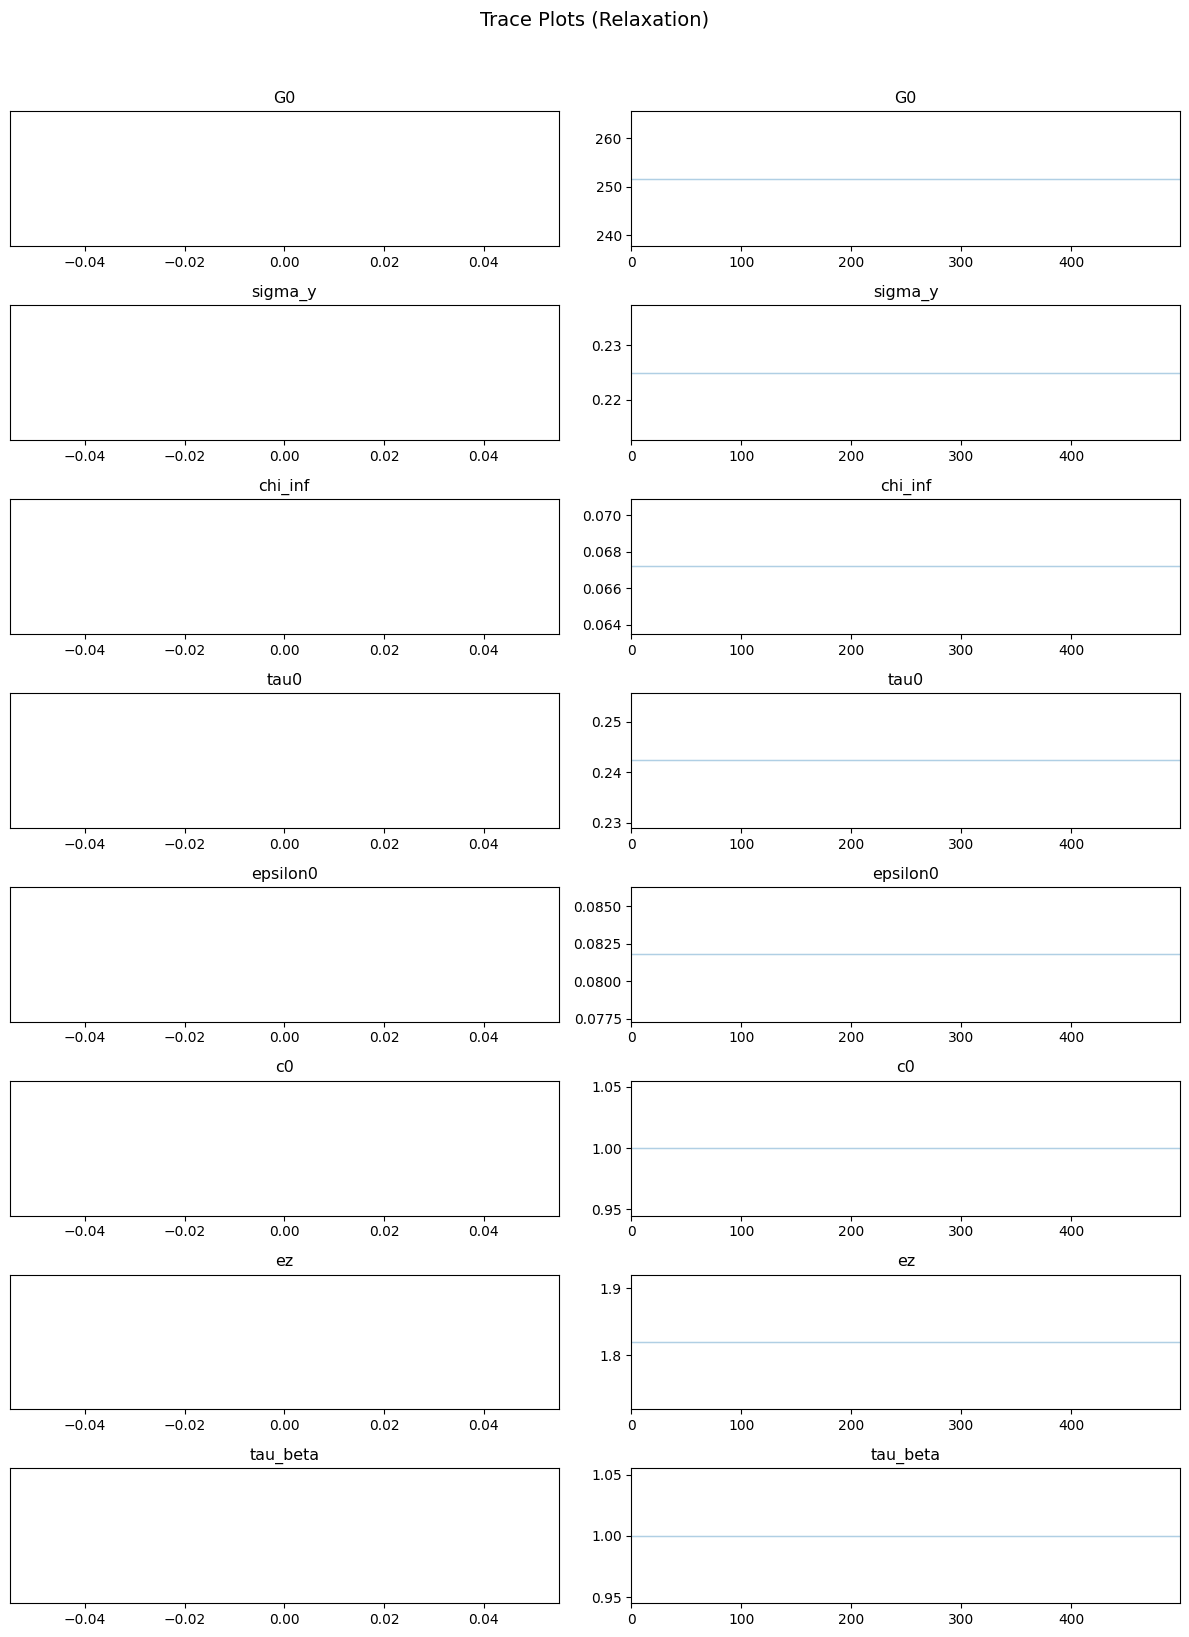

In [11]:
idata = result.to_inference_data()

axes = az.plot_trace(idata, var_names=relax_params, figsize=(12, 16))
fig = axes.ravel()[0].figure
fig.suptitle("Trace Plots (Relaxation)", fontsize=14, y=1.02)
plt.tight_layout()
display(fig)
plt.close(fig)

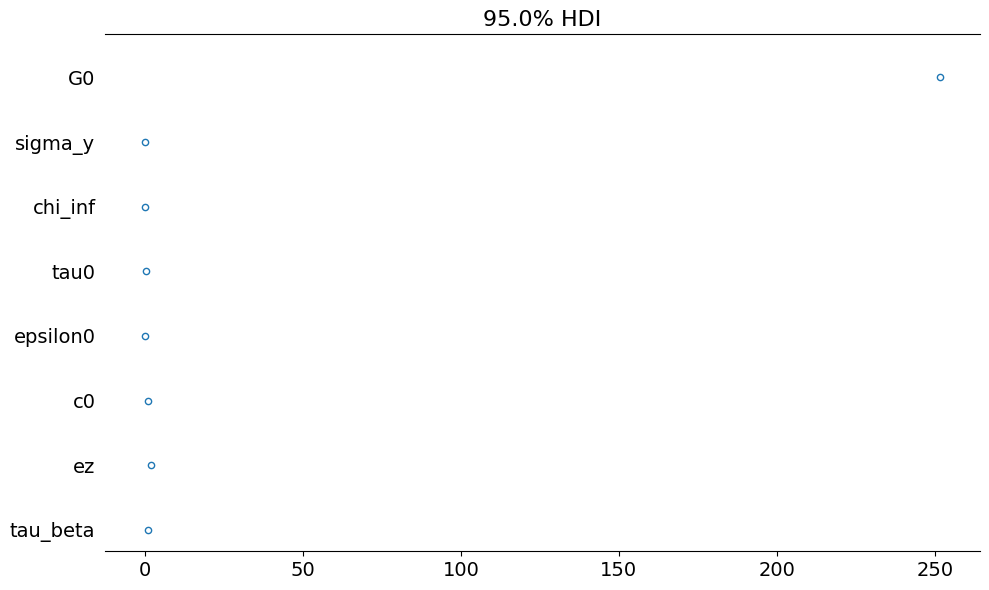

In [12]:
axes = az.plot_forest(
    idata,
    var_names=relax_params,
    combined=True,
    hdi_prob=0.95,
    figsize=(10, 6),
)
fig = axes.ravel()[0].figure
plt.tight_layout()
display(fig)
plt.close(fig)

In [13]:
posterior = result.posterior_samples
print_parameter_comparison(model, posterior, relax_params)


Parameter Comparison: NLSQ vs Bayesian
       Param          NLSQ        Median                    95% CI
-----------------------------------------------------------------
          G0         251.7         251.7  [251.7, 251.7]
     sigma_y         0.225         0.225  [0.225, 0.225]
     chi_inf       0.06719       0.06719  [0.06719, 0.06719]
        tau0        0.2424        0.2424  [0.2424, 0.2424]
    epsilon0       0.08181       0.08181  [0.08181, 0.08181]
          c0             1             1  [1, 1]
          ez          1.82          1.82  [1.82, 1.82]
    tau_beta             1             1  [1, 1]


## 7. Cross-Model Note: STZ vs SGR Relaxation

Both STZ and SGR can fit this laponite data, but with different physics:

| Feature | STZ | SGR |
|---------|-----|-----|
| Relaxation mechanism | Activated plastic rearrangements | Trap-hopping in energy landscape |
| Aging parameter | $\chi_{\infty}(t_{\text{wait}})$ decreases | $x(t_{\text{wait}})$ decreases |
| Functional form | ODE-based (exponential-like decay) | Power-law $G(t) \sim t^{x-2}$ |
| Parameters | 8 (ODE system) | 3 ($x$, $G_0$, $\tau_0$) |

See **SGR Notebook 02** for the SGR perspective on the same laponite data.

## 8. Save Results

In [14]:
from stz_tutorial_utils import save_stz_results

output_dir = os.path.join("..", "outputs", "stz", "relaxation")
save_stz_results(model, result, output_dir, "relaxation")

Results saved to ../outputs/stz/relaxation/
  nlsq_params_relaxation.json: 8 parameters
  posterior_relaxation.json: 500 draws


## Key Takeaways

1. **STZ relaxation = stress decay via plastic rearrangements** — even at gamma_dot=0, activated STZ events dissipate stored elastic energy
2. **chi_inf(t_wait) tracks physical aging** — deeper traps mean lower effective temperature and slower relaxation
3. **8 parameters from relaxation** — transient data activates G0, epsilon0, c0, tau_beta that are invisible to steady-state
4. **STZ vs SGR** — same data, different physics: activated events vs trap-hopping
5. **Laponite is a genuine STZ target** — colloidal glass with arrested disordered structure

## Next Steps

- **Notebook 04**: Creep with yield stress bifurcation
- **Notebook 02**: Startup shear with stress overshoot